In [1]:
import numpy as np
import os

def save_data(*arrays, folder="saved_data"):
    os.makedirs(folder, exist_ok=True)  # Create the folder if it doesn't exist
    filenames = [
        "train_set_branch_y.npy", "train_set_branch_t.npy", "train_set_trunk.npy",
        "branch_mask.npy", "test_truth.npy","samples.npy","samples_noisy.npy"
    ]
    for array, filename in zip(arrays, filenames):
        np.save(os.path.join(folder, filename), array)
    print("Data saved successfully.")

def load_data(folder="saved_data",postfix="train"):
    filenames = [
        "train_set_branch_y.npy", "train_set_branch_t.npy", "train_set_trunk.npy",
        "branch_mask.npy", "test_truth.npy","stats.npy","norm_props.npy","samples.npy","samples_noisy.npy"

    ]
    arrays = [np.load(os.path.join(folder+"_"+postfix, filename), allow_pickle=True) for filename in filenames]
    print("Data loaded successfully.")
    return arrays

grid_size = 640
temporal_size = 20

In [ ]:
import random
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import beta as beta_dist  # Import with a different name
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def prepare_data(num_functions,grid_size):
    # Parameters
      # Total number of functions to generate
    batch_size = 1        # Batch size for processing
    
    def periodic_kernel_matrix(X, length_scale=1.0, variance=1.0, p=0.1):
  
        X = np.asarray(X).reshape(-1, 1)
        abs_diff = np.abs(X - X.T)
        sin_squared = np.sin(np.pi * abs_diff / p) ** 2
        K = variance * np.exp(-2 * sin_squared / length_scale**2)
        return K

    def rbf_kernel_matrix(X, length_scale=1.0, variance=1.0):
        """
        Compute the RBF kernel matrix for input array X.
        """
        # Compute pairwise squared distances
        X = X.reshape(-1, 1)
        sqdist = np.sum(X**2, axis=1).reshape(-1, 1) + \
                np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
        K = variance * np.exp(-0.5 * sqdist / length_scale**2)
        return K
    def locally_periodic_kernel_matrix(X, length_scale=1.0, variance=1.0, p=0.1):

        X = np.asarray(X).reshape(-1, 1)    
        abs_diff = np.abs(X - X.T)    
        sin_squared = np.sin(np.pi * abs_diff / p) ** 2    
        k_per = variance * np.exp(-2 * sin_squared / length_scale**2)
        
        sq_diff = (X - X.T) ** 2
        

        k_se = np.exp(-sq_diff / (2 * length_scale**2))
        
        K = k_per * k_se
        
        return K

    def linear_kernel_matrix(X, variance=1.0):
        X = X.reshape(-1, 1)
        K = variance * np.dot(X, X.T)
        return K
    
    def linear_plus_periodic_kernel_matrix(X, lin_variance=1.0, per_length_scale=1.0, per_variance=1.0, p=0.1):
        K_lin = linear_kernel_matrix(X, variance=lin_variance)
        K_per = periodic_kernel_matrix(X, length_scale=per_length_scale, variance=per_variance, p=p)
        return K_lin + K_per 
    def get_kernel(X,l,v,p):
        import random
        r = random.uniform(0, 1)
        if r <0.2:
            return periodic_kernel_matrix(X,l,v,p)
        elif r >=.2 and r <.4:
            return rbf_kernel_matrix(X,l,v)
        elif r >=.4 and r <.6:
            return locally_periodic_kernel_matrix(X,l,v,p)
        elif r >=.6 and r <.8:
            return linear_kernel_matrix(X,v)
        elif r >=.8 and r <=1:
            return linear_plus_periodic_kernel_matrix(X,v,l,v,p)
    


    variance = 1.0           # Variance parameter σ²
    min = 50
    max = 90
    # Create input grid
    X = np.linspace(0, 1, grid_size)  # Points in [0, 1]


    train_set_branch_y_collection = []
    train_set_branch_t_collection = []

    train_set_trunk_collection = []
    branch_mask_collection = []
    test_truth_collection = []
    stats_collection = []

    samples_ = []
    samples_noisy_ = []
    i = 0
    train_params = [1.0,2.0,5.0]
    test_params = [2.0,4.0,7.0]
    for j in tqdm(range(num_functions), desc=f"NUM {i+1}/{100000}", leave=False):
        try:
            alpha, beta_param = np.random.choice(train_params ,1,replace=False)[0],np.random.choice(train_params, 1,replace=False)[0]
            i = j
            if j % 1000 == 0:
                print(j)
            l,p = beta_dist.rvs(alpha, beta_param),beta_dist.rvs(alpha, beta_param)
            K = get_kernel(X,l,variance,p)

            mean = np.zeros(grid_size)
            noise_std = np.abs(np.random.normal(0, 0.1))

            samples = np.random.multivariate_normal(mean, K, size=1).reshape(-1)
            samples_noisy = samples.copy() + np.random.normal(0, noise_std, size=grid_size)
            
            samples = samples.reshape(5,-1)
            samples_noisy = samples_noisy.reshape(5,-1)

            train_set_branch_y = np.zeros(shape=(5, grid_size//5))
            train_set_branch_t = np.zeros(shape=(5, grid_size//5))
            test_truth = np.zeros(shape=(5, grid_size//5))

            stats = np.zeros(shape=(5, 8))


            branch_mask = np.zeros(shape=(5, grid_size//5))

            train_set_trunk_t = X.copy().reshape(5,grid_size//5)

            shape = samples_noisy.shape[0]
           
            for i in range(0,shape):
                r = random.randint(min, max)
               
                if j < num_functions/2: 
                    indices = np.sort(np.random.choice(np.arange(0, grid_size//5), r, replace=False))
                else:
                    indices = np.arange(0, grid_size//5)[::random.randint(2, 4)]
               
                y_observed = samples_noisy[i][indices]
                y_truth = samples[i]
                t_truth =X.reshape(5,grid_size//5)[i]
                t_observed = X.reshape(5,grid_size//5)[i][indices]
                
               # y_min_truth,y_max_truth = (np.min(y_truth),np.max(y_truth))
               # y_min_noise,y_max_noise = (np.min(y_observed),np.max(y_observed))
                y_mean_truth,y_std_truth = (np.mean(y_truth),np.std(y_truth))     
                y_mean_noise,y_std_noise = (np.mean(y_observed),np.std(y_observed))

         #       y_range,y_f,y_l,y_d =  (y_max_noise - y_min_noise,y_observed[0], y_observed[-1],y_observed[-1] - y_observed[0])
         
              
                t_min,t_max,t_range,t_f,t_l,t_d = (np.min(t_observed),np.max(t_observed),
                                                np.max(t_observed) - np.min(t_observed),
                                                t_observed[0],t_observed[-1],
                                                t_observed[-1] - t_observed[0])  
                
             
                #norm
         #       print(y_observed - y_truth[indices])
                y_observed = (y_observed - y_mean_noise)/y_std_noise#(y_max_noise-y_min_noise)
                y_truth =  (y_truth - y_mean_noise)/y_std_noise#(y_max_truth-y_min_truth)
                t_observed = (t_observed - t_min)/(t_max-t_min)
                t_truth = (t_truth - t_min)/(t_max-t_min)
                
             #   print(y_min_truth,y_min_noise)
              #  print(y_max_truth,y_max_noise)
            #    print(y_observed - y_truth[indices])
        #       raise Exception()

                train_set_branch_y[i] = np.append(y_observed,np.zeros(grid_size//5 - len(indices)))         
                train_set_branch_t[i] = np.append(t_observed,np.zeros(grid_size//5 - len(indices)))
                train_set_trunk_t[i] = t_truth
                branch_mask[i]  = np.append(np.ones(len(indices)), np.zeros(grid_size//5 - len(indices)))
                test_truth[i] = y_truth
                stats[i] =np.array([y_mean_noise,y_std_noise,t_min,t_max,t_range,t_f,t_l,t_d]) #np.array([y_min_noise,y_max_noise,y_range,y_f,y_l,y_d,t_min,t_max,t_range,t_f,t_l,t_d])
            #    raise Exception()
            train_set_branch_y_collection.append(train_set_branch_y)
            train_set_branch_t_collection.append(train_set_branch_t)
            train_set_trunk_collection.append(train_set_trunk_t)
            branch_mask_collection.append(branch_mask)
            test_truth_collection.append(test_truth)
            stats_collection.append(stats)
            samples_.append(samples)
            samples_noisy_.append(samples_noisy)
            
        except :

            continue
    train_set_branch_y_collection = (np.asarray(train_set_branch_y_collection, dtype=np.float32)).reshape(num_functions*5,-1)
    train_set_branch_t_collection = (np.asarray(train_set_branch_t_collection, dtype=np.float32)).reshape(num_functions*5,-1)
    train_set_trunk_collection = (np.asarray(train_set_trunk_collection, dtype=np.float32)).reshape(num_functions*5,-1)
    branch_mask_collection = (np.asarray(branch_mask_collection, dtype=np.float32)).reshape(num_functions*5,-1)
    test_truth_collection = (np.asarray(test_truth_collection, dtype=np.float32)).reshape(num_functions*5,-1)
    stats_collection = (np.asarray(stats_collection, dtype=np.float32)).reshape(num_functions*5,-1)

    samples_ = (np.asarray(samples_, dtype=np.float32)).reshape(num_functions*5,-1)
    samples_noisy_ = (np.asarray(samples_noisy_, dtype=np.float32)).reshape(num_functions*5,-1)


    return (train_set_branch_y_collection,
            train_set_branch_t_collection,
            train_set_trunk_collection,
            branch_mask_collection,
            test_truth_collection,
            stats_collection,
            samples_,samples_noisy_)






In [5]:
grid_size = 640
num_f = 10000
data = prepare_data(num_f,grid_size)
save_data(*data)




0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Data saved successfully.


In [3]:
(train_set_branch_y, train_set_branch_t, train_set_trunk_t,
 branch_mask, test_truth,samples,samples_noisy) = load_data()

train_set_branch_y.shape


Data loaded successfully.


(500000, 128)

In [4]:
"""import matplotlib.pyplot as plt

# Daten laden
a = 54

(train_set_branch_y, train_set_branch_t, train_set_trunk_t,
 branch_mask, test_truth, samples, samples_noisy) = load_data()
train_set_branch_y = train_set_branch_y[a]
train_set_branch_t = train_set_branch_t[a]

train_set_trunk_t = train_set_trunk_t[a]
test_truth = test_truth[a]

samples = samples[a]#.reshape(1,-1)


print(train_set_trunk_t)

x = np.linspace(0,1,128) # Assuming samples is a 1D array of length 640

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot 'samples' as blue dots
#plt.scatter(x, samples, color='blue', label='Samples', s=10)  # s=10 sets the marker size

# Plot 'train_set_branch_y' as red dots
plt.scatter(train_set_trunk_t, test_truth, color='red', label='Test Set Branch Y', s=10)
plt.scatter(train_set_branch_t, train_set_branch_y, color='blue', label='Train Set Branch Y', s=10)


# Achsen beschriften und Titel hinzufügen
plt.xlabel('Time Index')
plt.ylabel('Function Value')
plt.title('Scatter Plot of Samples and Train Set Branch Y')

# Add a legend to differentiate the datasets
plt.legend()


# Plot anzeigen
plt.show()"""

"import matplotlib.pyplot as plt\n\n# Daten laden\na = 54\n\n(train_set_branch_y, train_set_branch_t, train_set_trunk_t,\n branch_mask, test_truth, samples, samples_noisy) = load_data()\ntrain_set_branch_y = train_set_branch_y[a]\ntrain_set_branch_t = train_set_branch_t[a]\n\ntrain_set_trunk_t = train_set_trunk_t[a]\ntest_truth = test_truth[a]\n\nsamples = samples[a]#.reshape(1,-1)\n\n\nprint(train_set_trunk_t)\n\nx = np.linspace(0,1,128) # Assuming samples is a 1D array of length 640\n\n# Initialize the plot\nplt.figure(figsize=(10, 6))\n\n# Plot 'samples' as blue dots\n#plt.scatter(x, samples, color='blue', label='Samples', s=10)  # s=10 sets the marker size\n\n# Plot 'train_set_branch_y' as red dots\nplt.scatter(train_set_trunk_t, test_truth, color='red', label='Test Set Branch Y', s=10)\nplt.scatter(train_set_branch_t, train_set_branch_y, color='blue', label='Train Set Branch Y', s=10)\n\n\n# Achsen beschriften und Titel hinzufügen\nplt.xlabel('Time Index')\nplt.ylabel('Function Va

In [2]:


import torch
import torch.nn as nn

class DeepONet(torch.nn.Module):

    def __init__(self, d_model, heads=1):
        super(DeepONet, self).__init__()
        self.branch_embedding_y = nn.Sequential(nn.Linear(1, d_model))
      
        self.embedding_t_branch =   nn.Sequential(nn.Linear(1, d_model))
        self.embedding_t_trunk =   nn.Sequential(nn.Linear(1, d_model))

        self.branch_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=2*d_model, nhead=heads, batch_first=True), num_layers=6, enable_nested_tensor=False)
     
        
        self.branch_attention = nn.MultiheadAttention(2*d_model, 1 ,batch_first=True)

        self.learnable_q = nn.Parameter(torch.randn(1,2*d_model))

        self.trunk_mlp =   nn.Sequential(nn.Linear(d_model, d_model),nn.LeakyReLU(),
                                         nn.LayerNorm(d_model),
                                         nn.Linear(d_model, d_model),nn.LeakyReLU(),
                                         nn.Linear(d_model, d_model),nn.LeakyReLU(),
                                         nn.LayerNorm(d_model),
                                         nn.Linear(d_model, d_model),nn.LeakyReLU())  
        
        self.branch_mlp =   nn.Sequential(nn.Linear(2*d_model, 2*d_model),nn.LeakyReLU(),
                                         nn.LayerNorm(2*d_model),
                                         nn.Linear(2*d_model, 2*d_model),nn.LeakyReLU(),
                                         nn.LayerNorm(2*d_model, 2*d_model))
        
        self.final_proj = nn.Sequential(nn.Linear(3*d_model, 1024),nn.LeakyReLU(),
                                         nn.LayerNorm(1024),
                                         nn.Linear(1024, 1024),nn.LeakyReLU(),
                                         nn.Linear(1024, 1024),nn.LeakyReLU(),
                                    
                                         nn.Linear(1024, d_model),nn.LeakyReLU(),
                                         nn.LayerNorm(d_model),
                                         nn.Linear(d_model, 1),)
        
    def forward(self, y, t, t_sample, y_mask):
        y = y.unsqueeze(-1) * y_mask.unsqueeze(-1)
        t = t.unsqueeze(-1) * y_mask.unsqueeze(-1)
        t_sample = t_sample.unsqueeze(-1)

   
        branch_embedding_y = self.branch_embedding_y(y)
        branch_embedding_t = self.embedding_t_branch(t)
        trunk_embed = self.embedding_t_trunk(t_sample)

  

        y_mask_enc = torch.where(y_mask == 1, False, True)
      

        branch_encoder_input = (torch.cat((branch_embedding_y , branch_embedding_t),dim=-1))
   
        #
        branch_encoder_output = self.branch_encoder(branch_encoder_input, src_key_padding_mask=y_mask_enc)
        branch_encoder_output = self.branch_mlp(branch_encoder_output)
 

      #  branch_encoder_output = branch_encoder_output * y_mask.unsqueeze(-1)

        q = self.learnable_q.unsqueeze(0).expand(y.shape[0],-1,-1)
      
        branch_output,_ = self.branch_attention(q,branch_encoder_output,branch_encoder_output,key_padding_mask=y_mask_enc)
  
        trunk_output = self.trunk_mlp(trunk_embed) 
     


        combined = torch.cat((branch_output.expand(-1,trunk_output.shape[1],-1),trunk_output),dim=-1)
     
        return self.final_proj(combined).squeeze()

In [6]:

(train_set_branch_y, train_set_branch_t, train_set_trunk_t,
 branch_mask, test_truth,stats,samples,samples_noisy) = load_data("saved_data_train_minmax")

Data loaded successfully.


In [3]:

import torch.nn.utils as nn_utils
import math
import torch
from dataset import TimeSeriesDataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

class InverseSquareRootLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, init_lr, min_lr=1e-9, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.init_lr = init_lr
        self.min_lr = min_lr
        super(InverseSquareRootLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1
        if step < self.warmup_steps:
            # Linear warmup
            lr = self.init_lr * (step / self.warmup_steps)
        else:
            # Inverse square root decay
            lr = self.init_lr * math.sqrt(self.warmup_steps / step)

        # Ensure learning rate doesn't go below minimum
        lr = max(lr, self.min_lr)

        return [lr for _ in self.base_lrs]
    

(train_set_branch_y, train_set_branch_t, train_set_trunk_t,
 branch_mask, test_truth,samples,samples_noisy) = load_data()
dataset = TimeSeriesDataset(
    train_set_branch_y,
    train_set_branch_t,
    train_set_trunk_t,
    branch_mask,
    test_truth
)
epochs = 20
# Initialize the DataLoader
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
model = DeepONet(d_model=256,heads=4)
model = torch.compile(model)

model.to(device)
model.train()


print(f"Params: {sum(p.numel() for p in model.parameters())}")



optim = torch.optim.AdamW(model.parameters(),lr=1e-3)
lr_scheduler = InverseSquareRootLR(optim,warmup_steps=0,init_lr=1e-3,min_lr=1e-4)
scaler = torch.GradScaler()

loss = 0
for epoch in range(epochs):
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        train_set_branch_y = batch["train_set_branch_y"].to('cuda')#[0]
        train_set_branch_t = batch["train_set_branch_t"].to('cuda')#[0]

        train_set_trunk_t = batch["train_set_trunk"].to('cuda')#[0]

        branch_mask = batch["branch_mask"].to('cuda')#[0]
        
        test_truth = batch["test_truth"].to('cuda')# [0]
        #with torch.autocast(device_type='cuda', dtype=torch.bfloat16):  
        out = model(train_set_branch_y,train_set_branch_t,train_set_trunk_t,branch_mask)
        loss = ((out-test_truth)**2).mean() #mse

        loss.backward()
        #scaler.unscale_(optim)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optim.step()#scaler.step(optim)
        #scaler.update()
        if torch.isnan(loss).any():
            print(train_set_branch_y)
            raise Exception()
     #   print(loss)
        lr_scheduler.step()
        optim.zero_grad()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

        
    
    


FileNotFoundError: [Errno 2] No such file or directory: 'saved_data_train/norm_props.npy'

Data loaded successfully.
(100000, 128)


/tmp/ipykernel_920528/3083914725.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict((torch.load("model_fim_l.pth")))


torch.Size([1, 128])


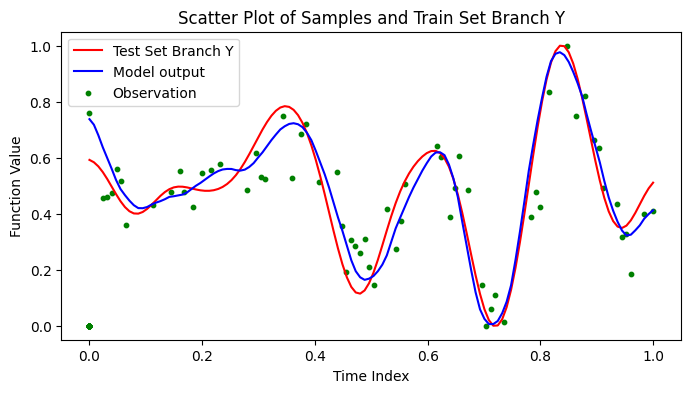

In [348]:
import torch
from dataset import TimeSeriesDataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from model import FIML
loss = 0
device = 'cuda'
epochs=1
(train_set_branch_y, train_set_branch_t, train_set_trunk_t,
 branch_mask, test_truth,stats,norm_props,samples,samples_noisy) =load_data(postfix="train_minmax_t1")

print(train_set_branch_y.shape)
dataset = TimeSeriesDataset(
    train_set_branch_y,
    train_set_branch_t,
    train_set_trunk_t,
    branch_mask,
    test_truth,
    stats,
    norm_props,
    samples
)
epochs = 20
# Initialize the DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
model = FIML(d_model=256,heads=4)
model.load_state_dict((torch.load("model_fim_l.pth")))
model.to(device)
model = torch.compile(model)
model.eval()

for epoch in range(epochs):

    for batch in dataloader:
        i = 0
        print(batch["train_set_branch_y"].to(device).shape)
        train_set_branch_y = batch["train_set_branch_y"].to(device)[i].unsqueeze(0)
        train_set_branch_t = batch["train_set_branch_t"].to(device)[i].unsqueeze(0)

        train_set_trunk_t = batch["train_set_trunk"].to(device)[i].unsqueeze(0)

        branch_mask = batch["branch_mask"].to(device)[i].unsqueeze(0)
        
        test_truth = batch["test_truth"].to(device) [i].unsqueeze(0)
              
        out,_ = model(train_set_branch_y,train_set_branch_t,train_set_trunk_t,branch_mask)
        
        x = np.linspace(0,1,128) # Assuming samples is a 1D array of length 640

        # Initialize the plot
        plt.figure(figsize=(8, 4))
       # print(train_set_branch_t[0])

        # Plot 'samples' as blue dots
        #plt.scatter(x, samples, color='blue', label='Samples', s=10)  # s=10 sets the marker size

        # Plot 'train_set_branch_y' as red dots

        plt.plot(train_set_trunk_t[0].to('cpu'), test_truth[0].to('cpu'), color='red', label='Test Set Branch Y', )
       # print(train_set_trunk_t[0].to('cpu').shape, out.to('cpu').detach().shape)
        plt.plot(train_set_trunk_t[0].to('cpu'), out.to('cpu').detach().numpy(), color='blue', label='Model output',)
        plt.scatter(train_set_branch_t[0].to('cpu'), train_set_branch_y[0].to('cpu').detach().numpy(), color='green', label='Observation', s=10)

        # Achsen beschriften und Titel hinzufügen
        plt.xlabel('Time Index')
        plt.ylabel('Function Value')
        plt.title('Scatter Plot of Samples and Train Set Branch Y')

        # Add a legend to differentiate the datasets
        plt.legend()


        # Plot anzeigen
        plt.show()
        break
    break

#torch.save(model._orig_mod.state_dict(), 'model.pth')


Data loaded successfully.


/tmp/ipykernel_920528/797526217.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict((torch.load("model_megatron_2.pth")))


torch.Size([2, 128])


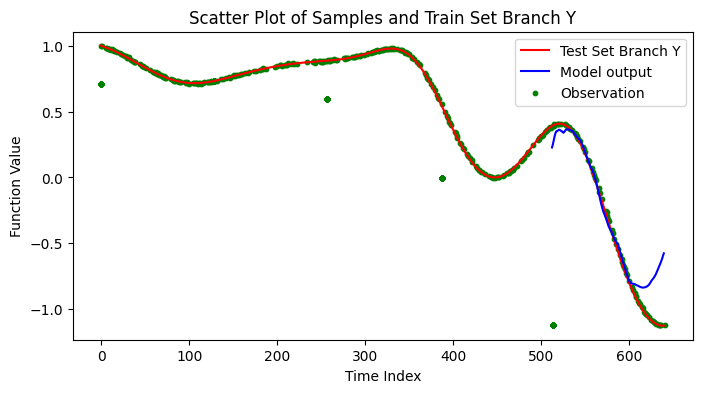

In [211]:
import torch
from dataset import TimeSeriesDataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from model import MegaTron
loss = 0
device = 'cuda'
epochs=1
(train_set_branch_y, train_set_branch_t, train_set_trunk_t,
 branch_mask, test_truth,stats,norm_props,samples,samples_noisy) =load_data(postfix="train_minmax_big")


#print(train_set_branch_y.shape)
n = 0
dataset = TimeSeriesDataset(
    train_set_branch_y.reshape(-1,5,grid_size//5)[n:],
    train_set_branch_t.reshape(-1,5,grid_size//5)[n:],
    train_set_trunk_t.reshape(-1,5,grid_size//5)[n:],
    branch_mask.reshape(-1,5,grid_size//5)[n:],
    test_truth.reshape(-1,5,grid_size//5)[n:],
    stats.reshape(-1,5,9)[n:],
    norm_props.reshape(-1,5,4)[n:],
    samples.reshape(-1,5,grid_size//5)[n:],
)
epochs = 20
# Initialize the DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
model = MegaTron(d_model=256,heads=8)
model.load_state_dict((torch.load("model_megatron_2.pth")))
model.to(device)
model.eval()

for epoch in range(epochs):

    for batch in dataloader:
        i = 0
        train_set_branch_y = batch["train_set_branch_y"].to(device)
        train_set_branch_t = batch["train_set_branch_t"].to(device)

        train_set_trunk_t = batch["train_set_trunk"].to(device)

        branch_mask = batch["branch_mask"].to(device)
        
        test_truth = batch["test_truth"].to(device)
        stats = batch["stats"].to(device)
        norm_props = batch["norm_props"].to(device)


        sample = batch["samples"].to(device)

              
    #
        out,cosine_sim = model(train_set_branch_y,train_set_branch_t,train_set_trunk_t,branch_mask,stats)
        print(out.shape)
   #     x = np.linspace(0,1,128) # Assuming samples is a 1D array of length 640

        # Initialize the plot
        plt.figure(figsize=(8, 4))
       # print(train_set_branch_t[0])

        # Plot 'samples' as blue dots
        #plt.scatter(x, samples, color='blue', label='Samples', s=10)  # s=10 sets the marker size

        # Plot 'train_set_branch_y' as red dots
        plt.plot( sample[0].reshape(-1).to('cpu'), color='red', label='Test Set Branch Y', )
    #    plt.plot(samples.reshape(-1), color='green', label='Test Set Branch Y', )

       # print(train_set_trunk_t[0].to('cpu').shape, out.to('cpu').detach().shape)
        plt.plot(np.arange(512,640, dtype=int),out[0].to('cpu').detach().numpy(), color='blue', label='Model output',)

        for i in range( 0,5):
          
            t_min,t_max = norm_props[0][i][-2],norm_props[0][i][-1]
            y_min,y_max = norm_props[0][i][0],norm_props[0][i][1]

            train_set_branch_t[0][i] = (train_set_branch_t[0][i] *(t_max-t_min) + t_min) 
            train_set_branch_t[0][i] *= (5 * 128)
            train_set_branch_y[0][i] = train_set_branch_y[0][i]   *(y_max-y_min) + y_min


        

        plt.scatter(train_set_branch_t[0].view(-1).to('cpu'), train_set_branch_y[0].reshape(-1).to('cpu').detach().numpy(), color='green', label='Observation', s=10)

        # Achsen beschriften und Titel hinzufügen
        plt.xlabel('Time Index')
        plt.ylabel('Function Value')
        plt.title('Scatter Plot of Samples and Train Set Branch Y')

        # Add a legend to differentiate the datasets
        plt.legend()


        # Plot anzeigen
        plt.show()
        break
    break

#torch.save(model._orig_mod.state_dict(), 'model.pth')


17420


/home/jan/Uni/Lab_-Zero_Shot/Jan/model.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.fim_l.load_state_dict((torch.load("model_fim_l.pth")))
/tmp/ipykernel_920528

17420


/home/jan/Uni/Lab_-Zero_Shot/Jan/model.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.fim_l.load_state_dict((torch.load("model_fim_l.pth")))
/tmp/ipykernel_920528

17420


/home/jan/Uni/Lab_-Zero_Shot/Jan/model.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.fim_l.load_state_dict((torch.load("model_fim_l.pth")))
/tmp/ipykernel_920528

17420


/home/jan/Uni/Lab_-Zero_Shot/Jan/model.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.fim_l.load_state_dict((torch.load("model_fim_l.pth")))
/tmp/ipykernel_920528

17420


/home/jan/Uni/Lab_-Zero_Shot/Jan/model.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.fim_l.load_state_dict((torch.load("model_fim_l.pth")))
/tmp/ipykernel_920528

17420


/home/jan/Uni/Lab_-Zero_Shot/Jan/model.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.fim_l.load_state_dict((torch.load("model_fim_l.pth")))
/tmp/ipykernel_920528

17420


/home/jan/Uni/Lab_-Zero_Shot/Jan/model.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.fim_l.load_state_dict((torch.load("model_fim_l.pth")))
/tmp/ipykernel_920528

17420


/home/jan/Uni/Lab_-Zero_Shot/Jan/model.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.fim_l.load_state_dict((torch.load("model_fim_l.pth")))
/tmp/ipykernel_920528

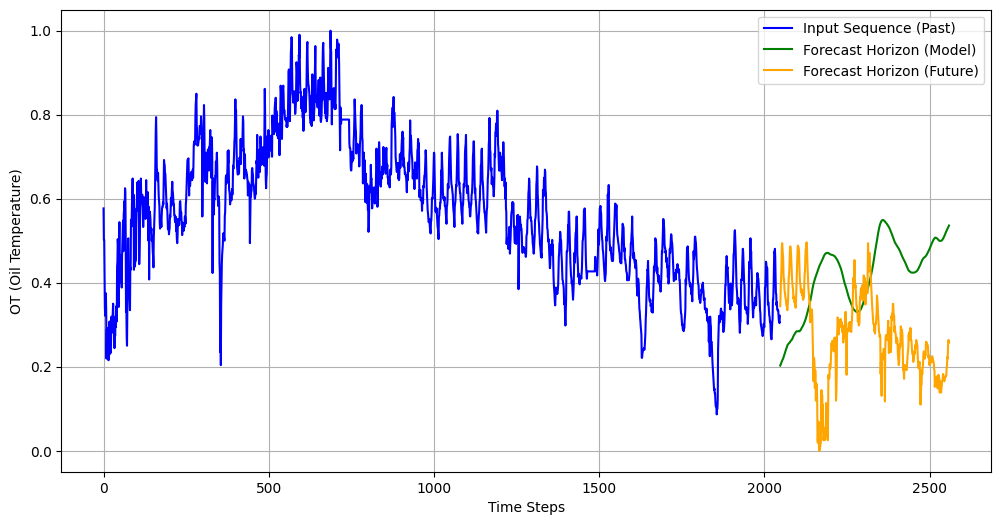

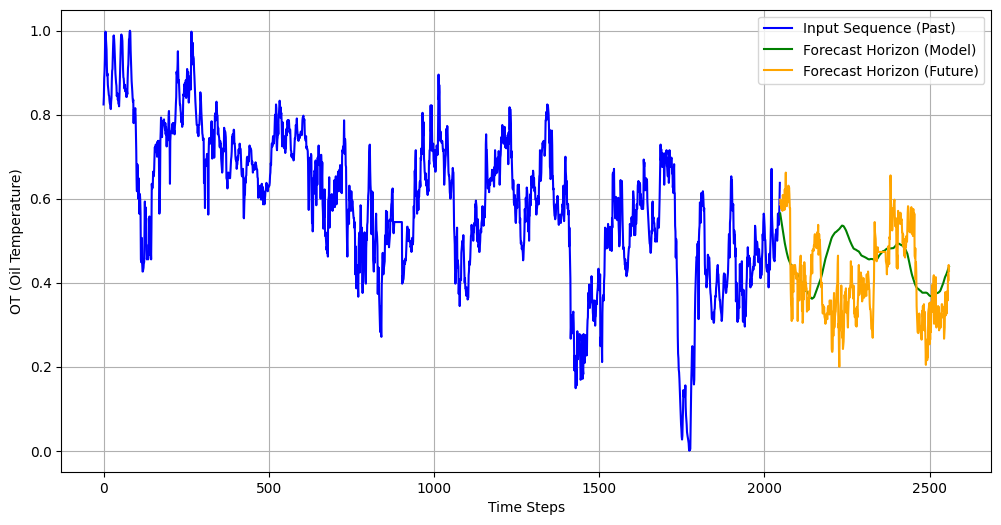

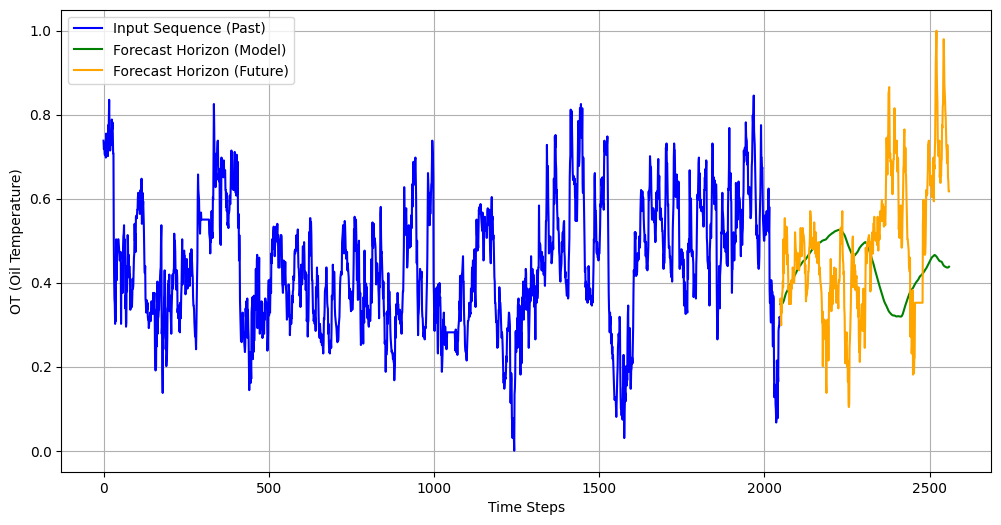

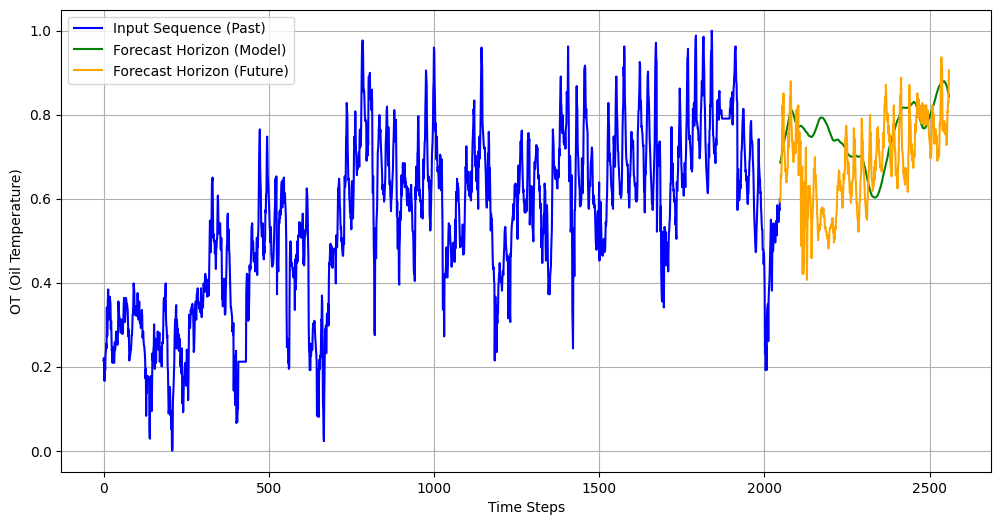

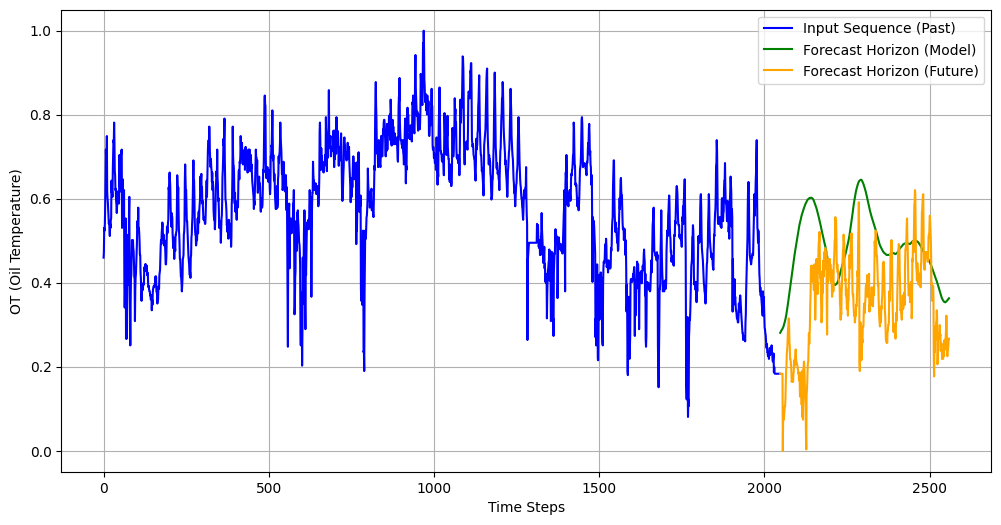

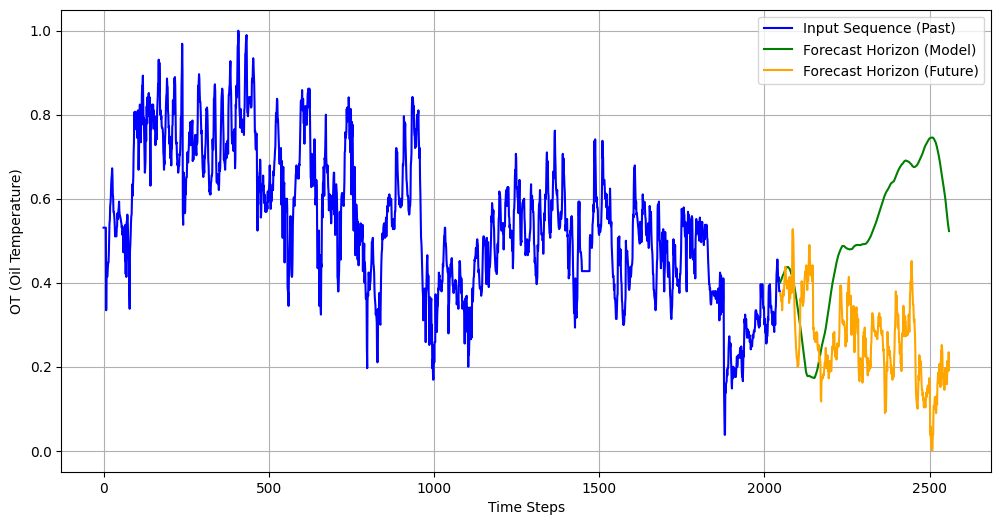

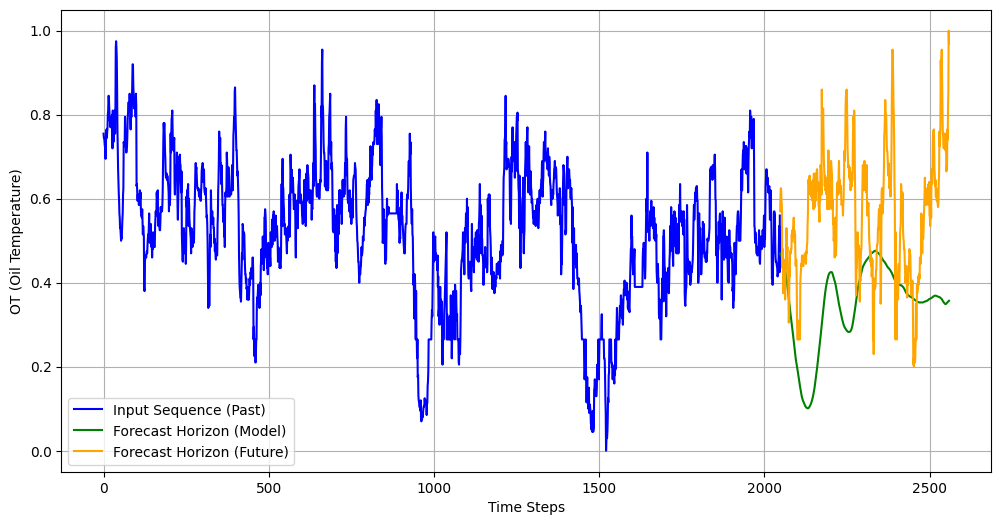

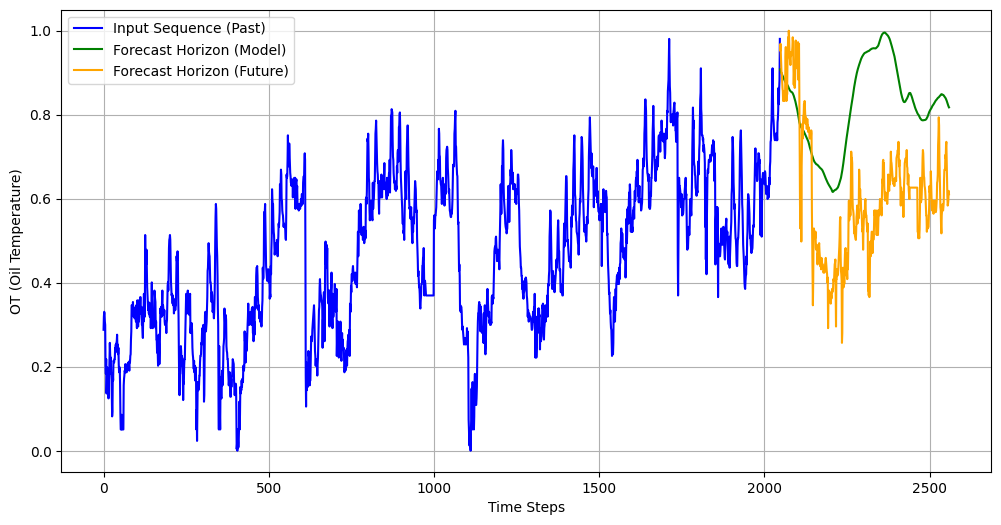

In [342]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
device = 'cuda'

def plot_etth_sample(file_path, input_length=336, horizon=96, start_index=0):
    """
    Plots a single sample from the ETTh1 dataset.
    
    Parameters:
    - file_path: Path to the ETTh1 CSV file.
    - input_length: Number of past steps to use as input.
    - horizon: Number of future steps to forecast.
    - sample_index: The index of the sample to plot.
    """
    # Load dataset
    df = pd.read_csv(file_path)
    
    # Use the "OT" column as the target variable
    target = df['OT'].values
    print(len(target))
    
    # Create a sliding window of samples
    samples = []
   
    input_sequence = target[start_index:start_index + input_length] 
    forecast_sequence = target[start_index + input_length:start_index + input_length + horizon] 


    g_min,g_max = (min(np.min(input_sequence),np.min(forecast_sequence)),max(np.max(input_sequence),np.max(forecast_sequence)))
   # print(g_min,g_max)
    input_sequence = (input_sequence - g_min)/(g_max - g_min)
    forecast_sequence = (forecast_sequence - g_min)/(g_max - g_min)


    s = np.concatenate((np.array(input_sequence), np.array(forecast_sequence))).reshape(5,-1) 
    X = np.linspace(0, 1,input_length + horizon).reshape(5,-1) 

    train_set_branch_y = np.zeros(shape=(5,s.shape[1]))
    train_set_branch_t = np.zeros(shape=(5, s.shape[1]))
    train_set_trunk_t = np.zeros(shape=(5, s.shape[1]))
    stats = np.zeros(shape=(5, 9))
    branch_mask = np.ones(shape=(5, s.shape[1]))

    for i in range(0,5):
        
      y_min,y_max = (np.min(s[i]),np.max(s[i]))
      t_min,t_max = (np.min(X[i]),np.max(X[i]))

      train_set_branch_y[i] = (s[i] - y_min)/(y_max - y_min)
      train_set_branch_t[i] = (X[i] - t_min)/(t_max - t_min)
      train_set_trunk_t[i] =  (X[i] - t_min)/(t_max - t_min)

      stats[i] =np.array([y_min,y_max,
                          y_max - y_min,
                          s[i][0],s[i][-1],
                          s[i][-1] - s[i][0],
                          X[i][0],X[i][-1],
                          X[i][-1] - X[i][0]])
      
   


    train_set_branch_y =  torch.tensor(train_set_branch_y,dtype=torch.float32).to(device).unsqueeze(0)
    train_set_branch_t =  torch.tensor(train_set_branch_t,dtype=torch.float32).to(device).unsqueeze(0)
    train_set_trunk_t =  torch.tensor(train_set_trunk_t,dtype=torch.float32).to(device).unsqueeze(0)
    stats =  torch.tensor(stats,dtype=torch.float32).to(device).unsqueeze(0)
    branch_mask =  torch.tensor(branch_mask,dtype=torch.float32).to(device).unsqueeze(0)

    model = MegaTron(d_model=256,heads=8)
    model.load_state_dict((torch.load("model_megatron_2.pth")))

    model = torch.compile(model)

    model.to(device)
    model.eval()


    out,cosine_sim = model(train_set_branch_y,train_set_branch_t,train_set_trunk_t,branch_mask,stats)
  #  print(out.shape)
  #  print(len(input_sequence+forecast_sequence))
    
    # Plot the input and forecast
    plt.figure(figsize=(12, 6))

   # input_sequence = input_sequence * (g_max - g_min) + g_min
    #forecast_sequence = forecast_sequence * (g_max - g_min) + g_min
    out =  out.to('cpu').detach().numpy()
    #out = out * (g_max - g_min) + g_min


    plt.plot(range(input_length), input_sequence, label="Input Sequence (Past)", color="blue")
    plt.plot(range(input_length, input_length + horizon), out, label="Forecast Horizon (Model)", color="green")
    plt.plot(range(input_length, input_length + horizon), forecast_sequence, label="Forecast Horizon (Future)", color="orange")

   # plt.axvline(x=input_length, color="red", linestyle="--", label="Forecast Start")
    plt.xlabel("Time Steps")
    plt.ylabel("OT (Oil Temperature)")
    plt.legend()
    plt.grid()
   

# Example usage
import random 

for i in range(0,8):
  start_index = i*2048#random.randint(0, 2000)

  plot_etth_sample("etth/ETTh1.csv", input_length=2048, horizon=512, start_index=start_index)
plt.show()

EE
(1, 5, 128)


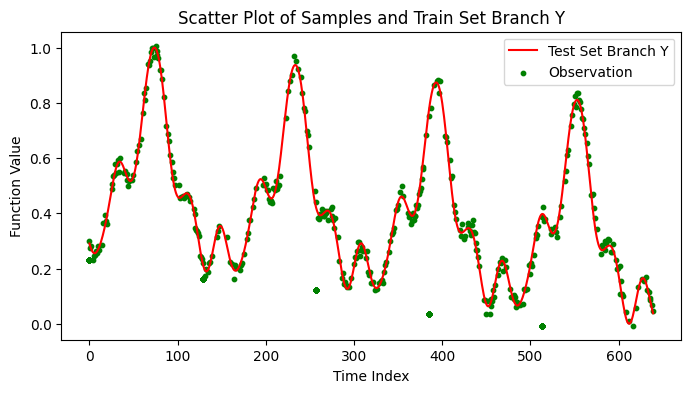

In [ ]:

import matplotlib.pyplot as plt

from scipy.stats import beta as beta_dist  # Import with a different name
import random

def prepare_data(num_functions,grid_size,train=True):
    # Parameters
      # Total number of functions to generate
    batch_size = 1        # Batch size for processing
    
    def periodic_kernel_matrix(X, length_scale=1.0, variance=1.0, p=0.1):
  
        X = np.asarray(X).reshape(-1, 1)
        abs_diff = np.abs(X - X.T)
        sin_squared = np.sin(np.pi * abs_diff / p) ** 2
        K = variance * np.exp(-2 * sin_squared / length_scale**2)
        return K

    def rbf_kernel_matrix(X, length_scale=1.0, variance=1.0):
        """
        Compute the RBF kernel matrix for input array X.
        """
        # Compute pairwise squared distances
        X = X.reshape(-1, 1)
        sqdist = np.sum(X**2, axis=1).reshape(-1, 1) + \
                np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
        K = variance * np.exp(-0.5 * sqdist / length_scale**2)
        return K
    def locally_periodic_kernel_matrix(X, length_scale=1.0, variance=1.0, p=0.1):

        X = np.asarray(X).reshape(-1, 1)    
        abs_diff = np.abs(X - X.T)    
        sin_squared = np.sin(np.pi * abs_diff / p) ** 2    
        k_per = variance * np.exp(-2 * sin_squared / length_scale**2)
        
        sq_diff = (X - X.T) ** 2
        

        k_se = np.exp(-sq_diff / (2 * length_scale**2))
        
        K = k_per * k_se
        
        return K

    def linear_kernel_matrix(X, variance=1.0):
        X = X.reshape(-1, 1)
        K = variance * np.dot(X, X.T)
        return K
    
    def linear_plus_periodic_kernel_matrix(X, lin_variance=1.0, per_length_scale=1.0, per_variance=1.0, p=0.1):
        K_lin = linear_kernel_matrix(X, variance=lin_variance)
        K_per = periodic_kernel_matrix(X, length_scale=per_length_scale, variance=per_variance, p=p)
        return K_lin + K_per 
    def get_kernel(X,l,v,p):
        import random
        r = random.uniform(0, 1)
        if r <=0.3 and False:
            return periodic_kernel_matrix(X,l,v,p)
        elif False: #r > .3 and r <= .6:
            return locally_periodic_kernel_matrix(X,l,v,p)
        else:
            return linear_plus_periodic_kernel_matrix(X,v,l,v,p)
    


    variance = 20.0           # Variance parameter σ²
    min = 50
    max = 90
    # Create input grid
    X = np.linspace(0, 1, grid_size)  # Points in [0, 1]


    train_set_branch_y_collection = []
    train_set_branch_t_collection = []

    train_set_trunk_collection = []
    branch_mask_collection = []
    test_truth_collection = []
    stats_collection = []
    norm_props_collection = []

    samples_ = []
    samples_noisy_ = []

    i = 0
    train_dist = [1.0,2.0,5.0]
    test_dist = [.5,3.25,7.8]
    dist = train_dist if train else test_dist

    for j in tqdm(range(num_functions), desc=f"NUM {i+1}/{100000}", leave=False):
            alpha, beta_param = np.random.choice(dist, 1,replace=False)[0],np.random.choice(dist, 1,replace=False)[0]
            i = j
            l,p = beta_dist.rvs(alpha, beta_param),beta_dist.rvs(alpha, beta_param)
            K = get_kernel(X,.6,variance,0.)

            mean = np.zeros(grid_size)
            noise_std = np.abs(np.random.normal(0, 0.05))

            samples = np.random.multivariate_normal(mean, K, size=1).reshape(-1)


            samples = (samples - np.min(samples)) / (np.max(samples) - np.min(samples))

            samples_noisy = samples.copy() + np.random.normal(0, noise_std, size=grid_size)
            
            samples = samples.reshape(5,-1)
            samples_noisy = samples_noisy.reshape(5,-1)

            train_set_branch_y = np.zeros(shape=(5, grid_size//5))
            train_set_branch_t = np.zeros(shape=(5, grid_size//5))
            test_truth = np.zeros(shape=(5, grid_size//5))

            stats = np.zeros(shape=(5, 9))
            norm_props = np.zeros(shape=(5, 4))


            branch_mask = np.zeros(shape=(5, grid_size//5))

            train_set_trunk_t = X.copy().reshape(5,grid_size//5)

            shape = samples_noisy.shape[0]
           
            for i in range(0,shape):
                r = random.randint(min, max)
               
                if j < num_functions/2: 
                    indices = np.sort(np.random.choice(np.arange(0, grid_size//5), r, replace=False))
                else:
                    indices = np.arange(0, grid_size//5)[::random.randint(2, 4)]
               
                y_observed = samples_noisy[i][indices]
                y_truth = samples[i]
                t_truth =X.reshape(5,grid_size//5)[i]
                t_observed = X.reshape(5,grid_size//5)[i][indices]
           
                
                y_min_truth,y_max_truth = (np.min(y_truth),np.max(y_truth))
                y_min_noise,y_max_noise = (np.min(y_observed),np.max(y_observed))
            #    y_mean_truth,y_std_truth = (np.mean(y_truth),np.std(y_truth))     
             #   y_mean_noise,y_std_noise = (np.mean(y_observed),np.std(y_observed))
        
             

                y_observed_norm = (y_observed - y_min_noise)/(y_max_noise-y_min_noise)
                y_truth =  (y_truth - y_min_truth)/(y_max_truth-y_min_truth)
                t_observed_norm = (t_observed - np.min(t_observed))/(np.max(t_observed) - np.min(t_observed))
                t_truth = (t_truth - np.min(t_truth))/(np.max(t_truth)-np.min(t_truth))
                

                train_set_branch_y[i] = np.append(y_observed_norm,np.zeros(grid_size//5 - len(indices)))         
                train_set_branch_t[i] = np.append(t_observed_norm,np.zeros(grid_size//5 - len(indices)))
                train_set_trunk_t[i] = t_truth
                branch_mask[i]  = np.append(np.ones(len(indices)), np.zeros(grid_size//5 - len(indices)))
                test_truth[i] = y_truth
                stats[i] =np.array([y_min_noise,y_max_noise,
                                    y_max_noise - y_min_noise,
                                    y_observed[0],y_observed[-1],
                                    y_observed[-1] - y_observed[0],
                                    t_observed[0],t_observed[-1],
                                    t_observed[-1] - t_observed[0]])
                norm_props[i] = np.array([y_min_noise,y_max_noise,np.min(t_observed),np.max(t_observed)])
           
                                     #np.array([y_min_noise,y_max_noise,y_range,y_f,y_l,y_d,t_min,t_max,t_range,t_f,t_l,t_d])
            #    raise Exception()
            train_set_branch_y_collection.append(train_set_branch_y)
            train_set_branch_t_collection.append(train_set_branch_t)
            train_set_trunk_collection.append(train_set_trunk_t)
            branch_mask_collection.append(branch_mask)
            test_truth_collection.append(test_truth)
            stats_collection.append(stats)
            norm_props_collection.append(norm_props)

            
            samples_.append(samples)
            samples_noisy_.append(samples_noisy)
            
            print("EE")

    train_set_branch_y_collection = (np.asarray(train_set_branch_y_collection, dtype=np.float32)).reshape(-1,5,grid_size//5)
    train_set_branch_t_collection = (np.asarray(train_set_branch_t_collection, dtype=np.float32)).reshape(-1,5,grid_size//5)
    train_set_trunk_collection = (np.asarray(train_set_trunk_collection, dtype=np.float32)).reshape(-1,5,grid_size//5)
    branch_mask_collection = (np.asarray(branch_mask_collection, dtype=np.float32)).reshape(-1,5,grid_size//5)
    test_truth_collection = (np.asarray(test_truth_collection, dtype=np.float32).reshape(-1,5,grid_size//5))
    stats_collection = (np.asarray(stats_collection, dtype=np.float32)).reshape(-1,5,9)
    norm_props_collection = (np.asarray(norm_props_collection, dtype=np.float32)).reshape(-1,5,4)


    
    samples_ = (np.asarray(samples_, dtype=np.float32)).reshape(-1,5,grid_size//5)
    samples_noisy_ = (np.asarray(samples_noisy_, dtype=np.float32)).reshape(-1,5,grid_size//5)


    return (train_set_branch_y_collection,
            train_set_branch_t_collection,
            train_set_trunk_collection,
            branch_mask_collection,
            test_truth_collection,
            stats_collection,
            norm_props_collection,
            samples_,samples_noisy_)



grid_size = 640
num_f = 1
(train_set_branch_y, train_set_branch_t, train_set_trunk_t,
 branch_mask, test_truth,stats,norm_props,samples,samples_noisy) = prepare_data(num_f,grid_size)


print(samples.shape)
plt.figure(figsize=(8, 4))
# print(train_set_branch_t[0])

# Plot 'samples' as blue dots
#plt.scatter(x, samples, color='blue', label='Samples', s=10)  # s=10 sets the marker size

# Plot 'train_set_branch_y' as red dots
plt.plot( samples.reshape(-1), color='red', label='Test Set Branch Y', )
#    plt.plot(samples.reshape(-1), color='green', label='Test Set Branch Y', )

# print(train_set_trunk_t[0].to('cpu').shape, out.to('cpu').detach().shape)
#plt.plot(np.arange(512,640, dtype=int),out[0].to('cpu').detach().numpy(), color='blue', label='Model output',)

for i in range( 0,5):
    
    t_min,t_max = norm_props[0][i][-2],norm_props[0][i][-1]
    y_min,y_max = norm_props[0][i][0],norm_props[0][i][1]

    train_set_branch_t[0][i] = (train_set_branch_t[0][i] *(t_max-t_min) + t_min) 
    train_set_branch_t[0][i] *= (5 * 128)
    train_set_branch_y[0][i] = train_set_branch_y[0][i]   *(y_max-y_min) + y_min


plt.scatter(train_set_branch_t[0].reshape(-1), train_set_branch_y[0].reshape(-1), color='green', label='Observation', s=10)

# Achsen beschriften und Titel hinzufügen
plt.xlabel('Time Index')
plt.ylabel('Function Value')
plt.title('Scatter Plot of Samples and Train Set Branch Y')

# Add a legend to differentiate the datasets
plt.legend()


# Plot anzeigen
plt.show()

/tmp/ipykernel_920528/1430694979.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fim_model.load_state_dict((torch.load("model_fim_l.pth")))


torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])


/tmp/ipykernel_920528/1430694979.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict((torch.load("model_megatron_2.pth")))


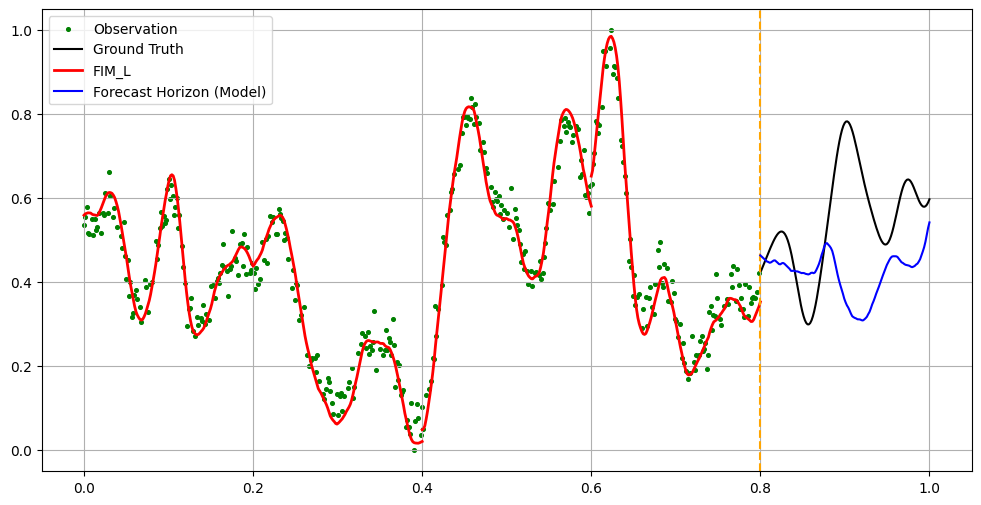

In [417]:
obs_grid = "0.00000 0.01878 0.03756 0.05634 0.07512 0.09390 0.11268 0.13146 0.15023 0.16901 0.18779 0.20657 0.22535 0.24413 0.26291 0.28169 0.30047 0.31925 0.33803 0.35681 0.37559 0.39437 0.41315 0.43192 0.45070 0.46948 0.48826 0.50704 0.52582 0.54460 0.56338 0.58216 0.60094 0.61972 0.63850 0.65728 0.67606 0.69484 0.71362 0.73239 0.75117 0.76995 0.78873 0.80751 0.82629 0.84507 0.86385 0.88263 0.90141 0.92019 0.93897 0.95775 0.97653 0.99531 1.01408 1.03286 1.05164 1.07042 1.08920 1.10798 1.12676 1.14554 1.16432 1.18310 1.20188 1.22066 1.23944 1.25822 1.27700 1.29577 1.31455 1.33333 1.35211 1.37089 1.38967 1.40845 1.42723 1.44601 1.46479 1.48357 1.50235 1.52113 1.53991 1.55869 1.57746 1.59624 1.61502 1.63380 1.65258 1.67136 1.69014 1.70892 1.72770 1.74648 1.76526 1.78404 1.80282 1.82160 1.84038 1.85915 1.87793 1.89671 1.91549 1.93427 1.95305 1.97183 1.99061 2.00939 2.02817 2.04695 2.06573 2.08451 2.10329 2.12207 2.14085 2.15962 2.17840 2.19718 2.21596 2.23474 2.25352 2.27230 2.29108 2.30986 2.32864 2.34742 2.36620 2.38498 2.40376 2.42254 2.44131 2.46009 2.47887 2.49765 2.51643 2.53521 2.55399 2.57277 2.59155 2.61033 2.62911 2.64789 2.66667 2.68545 2.70423 2.72300 2.74178 2.76056 2.77934 2.79812 2.81690 2.83568 2.85446 2.87324 2.89202 2.91080 2.92958 2.94836 2.96714 2.98592 3.00469 3.02347 3.04225 3.06103 3.07981 3.09859 3.11737 3.13615 3.15493 3.17371 3.19249 3.21127 3.23005 3.24883 3.26761 3.28638 3.30516 3.32394 3.34272 3.36150 3.38028 3.39906 3.41784 3.43662 3.45540 3.47418 3.49296 3.51174 3.53052 3.54930 3.56808 3.58685 3.60563 3.62441 3.64319 3.66197 3.68075 3.69953 3.71831 3.73709 3.75587 3.77465 3.79343 3.81221 3.83099 3.84977 3.86854 3.88732 3.90610 3.92488 3.94366 3.96244 3.98122 4.00000 4.01878 4.03756 4.05634 4.07512 4.09390 4.11268 4.13146 4.15023 4.16901 4.18779 4.20657 4.22535 4.24413 4.26291 4.28169 4.30047 4.31925 4.33803 4.35681 4.37559 4.39437 4.41315 4.43192 4.45070 4.46948 4.48826 4.50704 4.52582 4.54460 4.56338 4.58216 4.60094 4.61972 4.63850 4.65728 4.67606 4.69484 4.71362 4.73239 4.75117 4.76995 4.78873 4.80751 4.82629 4.84507 4.86385 4.88263 4.90141 4.92019 4.93897 4.95775 4.97653 4.99531 5.01408 5.03286 5.05164 5.07042 5.08920 5.10798 5.12676 5.14554 5.16432 5.18310 5.20188 5.22066 5.23944 5.25822 5.27700 5.29577 5.31455 5.33333 5.35211 5.37089 5.38967 5.40845 5.42723 5.44601 5.46479 5.48357 5.50235 5.52113 5.53991 5.55869 5.57746 5.59624 5.61502 5.63380 5.65258 5.67136 5.69014 5.70892 5.72770 5.74648 5.76526 5.78404 5.80282 5.82160 5.84038 5.85915 5.87793 5.89671 5.91549 5.93427 5.95305 5.97183 5.99061 6.00939 6.02817 6.04695 6.06573 6.08451 6.10329 6.12207 6.14085 6.15962 6.17840 6.19718 6.21596 6.23474 6.25352 6.27230 6.29108 6.30986 6.32864 6.34742 6.36620 6.38498 6.40376 6.42254 6.44131 6.46009 6.47887 6.49765 6.51643 6.53521 6.55399 6.57277 6.59155 6.61033 6.62911 6.64789 6.66667 6.68545 6.70423 6.72300 6.74178 6.76056 6.77934 6.79812 6.81690 6.83568 6.85446 6.87324 6.89202 6.91080 6.92958 6.94836 6.96714 6.98592 7.00469 7.02347 7.04225 7.06103 7.07981 7.09859 7.11737 7.13615 7.15493 7.17371 7.19249 7.21127 7.23005 7.24883 7.26761 7.28638 7.30516 7.32394 7.34272 7.36150 7.38028 7.39906 7.41784 7.43662 7.45540 7.47418 7.49296 7.51174 7.53052 7.54930 7.56808 7.58685 7.60563 7.62441 7.64319 7.66197 7.68075 7.69953 7.71831 7.73709 7.75587 7.77465 7.79343 7.81221 7.83099 7.84977 7.86854 7.88732 7.90610 7.92488 7.94366 7.96244 7.98122 8.00000 8.01878 8.03756 8.05634 8.07512 8.09390 8.11268 8.13146 8.15023 8.16901 8.18779 8.20657 8.22535 8.24413 8.26291 8.28169 8.30047 8.31925 8.33803 8.35681 8.37559 8.39437 8.41315 8.43192 8.45070 8.46948 8.48826 8.50704 8.52582 8.54460 8.56338 8.58216 8.60094 8.61972 8.63850 8.65728 8.67606 8.69484 8.71362 8.73239 8.75117 8.76995 8.78873 8.80751 8.82629 8.84507 8.86385 8.88263 8.90141 8.92019 8.93897 8.95775 8.97653 8.99531 9.01408 9.03286 9.05164 9.07042 9.08920 9.10798 9.12676 9.14554 9.16432 9.18310 9.20188 9.22066 9.23944 9.25822 9.27700 9.29577 9.31455 9.33333 9.35211 9.37089 9.38967 9.40845 9.42723 9.44601 9.46479 9.48357 9.50235 9.52113 9.53991 9.55869 9.57746 9.59624"
obs_values_noisy = "0.00000 2.86400 2.95212 3.06059 2.78144 2.77342 0.00000 2.93093 2.76060 2.93488 2.81305 2.84738 2.99253 0.00000 2.78206 2.99832 2.96968 3.20279 0.00000 2.98979 3.43029 3.17435 0.00000 2.95440 3.04838 0.00000 2.84785 0.00000 0.00000 2.74828 2.61566 2.89615 2.52935 2.28853 2.49108 2.11146 2.26062 1.87893 1.92689 2.11890 2.17350 2.07166 0.00000 1.99492 1.82793 0.00000 0.00000 2.27936 2.20832 1.93384 0.00000 2.23950 2.25289 0.00000 0.00000 2.69322 2.50124 2.65630 2.82841 2.99980 2.85300 2.96286 2.88268 2.91689 3.25346 3.35591 3.14667 3.29603 3.17034 2.97265 3.06051 3.15893 2.83187 2.97063 0.00000 2.63771 2.41376 2.24447 0.00000 1.78711 1.96450 1.97519 2.08067 1.73247 0.00000 1.67939 1.88434 1.80108 0.00000 1.87064 1.84265 2.01483 1.81111 1.91797 0.00000 1.85383 0.00000 2.21458 2.22203 0.00000 2.08479 2.26269 2.29666 2.24390 2.35081 2.44198 2.66754 2.41236 0.00000 2.37882 2.10698 2.39878 2.42335 2.79897 0.00000 2.51361 2.48483 2.33601 0.00000 2.65930 2.67621 2.42635 2.77192 2.34339 2.62773 0.00000 2.34917 2.38813 2.46367 2.35142 2.17739 2.41016 2.23896 0.00000 2.28704 2.68623 0.00000 2.49060 2.71417 2.46499 2.74291 2.96302 0.00000 2.89745 2.94865 0.00000 2.77188 2.76498 3.03415 2.98055 2.94164 2.91296 2.70604 2.78150 2.72239 2.49778 0.00000 0.00000 2.18889 2.38549 2.06108 2.24712 2.22658 1.85569 0.00000 1.90028 0.00000 1.99326 0.00000 1.47781 0.00000 1.36375 1.42761 1.44727 0.00000 1.44602 1.29279 1.48154 1.19997 0.00000 0.00000 1.05603 1.00934 0.00000 1.10950 1.23690 1.18732 1.09155 0.96121 0.84656 0.00000 0.00000 1.06558 0.83625 1.04158 1.06959 0.87992 1.04155 0.00000 0.00000 1.12701 1.18857 0.00000 1.34178 1.02336 1.13835 0.00000 0.00000 1.50353 0.00000 1.59419 1.71140 0.00000 1.68361 1.55113 1.71906 1.49147 1.57080 1.53066 1.61255 1.94523 1.31764 0.00000 0.00000 1.54129 0.00000 0.00000 1.47632 1.53597 1.74609 1.52954 1.65925 1.61308 1.47918 1.86028 1.58698 1.13352 1.40399 1.21022 1.36716 1.04828 1.07757 1.09957 0.00000 0.71189 0.78329 0.71006 0.63819 0.96359 0.00000 0.45993 0.77539 0.95433 0.79932 0.00000 0.62125 0.92589 0.68368 0.00000 1.05050 0.00000 1.11678 0.00000 1.20393 1.44746 1.43154 2.00067 1.68024 1.96774 0.00000 0.00000 2.22049 2.73589 2.68331 2.64964 2.97617 0.00000 3.02312 3.22089 3.24658 3.41235 0.00000 0.00000 3.46430 0.00000 3.50759 3.84469 4.01593 4.02211 3.92982 4.02529 4.00504 4.00167 4.21687 4.13053 3.94901 4.15279 4.01856 0.00000 3.94967 3.66169 0.00000 3.74646 3.64682 3.47317 3.41676 0.00000 0.00000 3.27604 3.10821 3.05840 3.21677 3.14513 3.12086 3.17965 2.97843 3.07413 2.92538 3.02240 0.00000 2.99004 0.00000 2.84050 3.26234 0.00000 2.71581 3.03562 2.93799 2.86450 2.81232 2.66047 2.47072 2.56023 2.39318 2.59098 2.37825 2.23911 0.00000 2.37546 2.21842 0.00000 2.34852 2.36823 0.00000 2.32846 2.48105 2.28422 2.35288 2.52551 2.67651 2.83569 3.09541 3.09157 3.03067 0.00000 3.09272 3.33479 0.00000 0.00000 3.48129 3.76195 3.98442 0.00000 3.92432 4.00371 3.86222 3.96368 3.92494 3.91640 3.75116 3.82432 0.00000 3.91841 0.00000 3.88602 3.38020 3.56346 3.40562 3.66319 3.18373 3.16507 3.20457 2.99777 3.27820 3.30249 3.51591 3.63772 3.97495 3.95435 3.85144 3.93364 0.00000 4.12755 4.71847 4.72615 4.56759 0.00000 0.00000 4.75181 4.94479 4.48095 4.56197 4.55598 4.43881 4.21657 0.00000 3.76945 3.70961 3.54220 3.39109 3.21172 0.00000 2.47855 2.72077 2.41611 2.11024 2.33221 2.01566 2.09598 0.00000 2.13357 0.00000 1.76877 1.96657 0.00000 2.09219 1.78893 2.08954 2.20249 0.00000 1.98512 1.91499 2.23574 0.00000 2.59687 2.41975 2.68113 2.24785 2.20613 2.44798 0.00000 2.40269 2.05420 0.00000 2.04794 2.26943 2.14239 1.86018 1.83570 1.66594 0.00000 1.80342 1.44002 1.60033 1.39241 1.31142 0.00000 1.22607 1.29011 0.00000 1.67923 1.40665 1.31864 1.48181 1.46139 1.47481 1.62995 1.68075 1.51586 1.53625 1.60760 1.32921 1.47280 1.93127 2.00033 1.74534 1.90044 1.89425 2.34528 2.08922 0.00000 1.85682 1.79833 0.00000 1.99786 0.00000 2.07036 2.02479 0.00000 2.33950 2.20664 2.42466 0.00000 2.04962 2.39106 2.22623 1.97309 2.08528 1.97076 1.88705 2.23062 0.00000 1.89231 2.19970 2.03570 2.08259 2.09280 2.08100 0.00000 2.14989 2.34894 0.00000"
obs_values_clean = "2.92112 2.88474 2.85497 2.83214 2.81656 2.80854 2.80827 2.81581 2.83102 2.85350 2.88256 2.91723 2.95623 2.99801 3.04080 3.08266 3.12161 3.15565 3.18289 3.20164 3.21045 3.20821 3.19421 3.16811 3.13004 3.08052 3.02050 2.95129 2.87451 2.79203 2.70592 2.61831 2.53137 2.44719 2.36769 2.29459 2.22929 2.17288 2.12611 2.08937 2.06273 2.04595 2.03861 2.04009 2.04971 2.06678 2.09066 2.12080 2.15678 2.19830 2.24517 2.29726 2.35443 2.41647 2.48303 2.55352 2.62713 2.70268 2.77872 2.85347 2.92487 2.99071 3.04863 3.09632 3.13158 3.15248 3.15747 3.14550 3.11609 3.06942 3.00630 2.92822 2.83724 2.73594 2.62727 2.51442 2.40070 2.28932 2.18328 2.08524 1.99745 1.92163 1.85899 1.81021 1.77551 1.75465 1.74703 1.75177 1.76774 1.79365 1.82809 1.86954 1.91642 1.96712 2.01998 2.07336 2.12567 2.17542 2.22127 2.26210 2.29710 2.32579 2.34807 2.36425 2.37501 2.38137 2.38461 2.38617 2.38750 2.38999 2.39479 2.40275 2.41432 2.42948 2.44779 2.46838 2.49004 2.51131 2.53064 2.54651 2.55756 2.56276 2.56150 2.55367 2.53971 2.52058 2.49775 2.47308 2.44872 2.42694 2.40999 2.39988 2.39831 2.40646 2.42495 2.45374 2.49216 2.53891 2.59215 2.64962 2.70879 2.76695 2.82145 2.86976 2.90967 2.93934 2.95743 2.96305 2.95586 2.93600 2.90406 2.86099 2.80804 2.74666 2.67843 2.60493 2.52770 2.44817 2.36758 2.28701 2.20728 2.12905 2.05279 1.97880 1.90728 1.83836 1.77215 1.70874 1.64826 1.59087 1.53675 1.48612 1.43917 1.39610 1.35701 1.32195 1.29084 1.26351 1.23967 1.21890 1.20073 1.18460 1.16997 1.15627 1.14302 1.12980 1.11633 1.10247 1.08823 1.07379 1.05949 1.04584 1.03346 1.02311 1.01560 1.01179 1.01250 1.01850 1.03039 1.04862 1.07334 1.10445 1.14150 1.18371 1.23001 1.27902 1.32919 1.37883 1.42628 1.46996 1.50856 1.54106 1.56689 1.58590 1.59842 1.60522 1.60740 1.60632 1.60346 1.60027 1.59803 1.59773 1.59996 1.60486 1.61208 1.62085 1.62997 1.63799 1.64326 1.64415 1.63909 1.62679 1.60625 1.57692 1.53869 1.49189 1.43729 1.37602 1.30948 1.23929 1.16716 1.09479 1.02382 0.95576 0.89193 0.83346 0.78130 0.73619 0.69877 0.66957 0.64906 0.63771 0.63601 0.64445 0.66357 0.69388 0.73585 0.78983 0.85599 0.93430 1.02442 1.12571 1.23720 1.35759 1.48535 1.61871 1.75581 1.89476 2.03374 2.17113 2.30553 2.43587 2.56142 2.68178 2.79686 2.90686 3.01213 3.11315 3.21042 3.30438 3.39532 3.48335 3.56836 3.64997 3.72759 3.80041 3.86746 3.92768 3.97996 4.02323 4.05651 4.07899 4.09008 4.08943 4.07697 4.05294 4.01785 3.97247 3.91784 3.85522 3.78604 3.71186 3.63436 3.55527 3.47630 3.39916 3.32545 3.25663 3.19398 3.13854 3.09105 3.05196 3.02132 2.99884 2.98383 2.97528 2.97184 2.97192 2.97378 2.97557 2.97549 2.97186 2.96324 2.94848 2.92683 2.89793 2.86190 2.81924 2.77088 2.71806 2.66231 2.60531 2.54886 2.49475 2.44471 2.40031 2.36293 2.33371 2.31352 2.30298 2.30242 2.31196 2.33148 2.36068 2.39912 2.44624 2.50143 2.56400 2.63327 2.70853 2.78905 2.87411 2.96292 3.05466 3.14840 3.24310 3.33756 3.43045 3.52027 3.60538 3.68405 3.75451 3.81505 3.86406 3.90019 3.92240 3.93007 3.92305 3.90175 3.86712 3.82065 3.76436 3.70074 3.63260 3.56304 3.49530 3.43261 3.37811 3.33472 3.30498 3.29103 3.29448 3.31635 3.35706 3.41636 3.49335 3.58646 3.69352 3.81179 3.93798 4.06840 4.19902 4.32558 4.44375 4.54924 4.63796 4.70621 4.75074 4.76899 4.75912 4.72011 4.65188 4.55520 4.43176 4.28408 4.11540 3.92959 3.73096 3.52415 3.31392 3.10498 2.90185 2.70867 2.52912 2.36627 2.22251 2.09954 1.99831 1.91908 1.86146 1.82446 1.80662 1.80611 1.82083 1.84853 1.88690 1.93367 1.98663 2.04372 2.10299 2.16261 2.22088 2.27615 2.32687 2.37152 2.40863 2.43684 2.45487 2.46164 2.45631 2.43834 2.40759 2.36432 2.30926 2.24361 2.16898 2.08740 2.00116 1.91278 1.82482 1.73982 1.66015 1.58788 1.52472 1.47195 1.43035 1.40021 1.38135 1.37316 1.37464 1.38452 1.40136 1.42360 1.44971 1.47824 1.50795 1.53782 1.56712 1.59543 1.62263 1.64886 1.67449 1.70008 1.72623 1.75359 1.78269 1.81395 1.84756 1.88345 1.92129 1.96047 2.00015 2.03930 2.07675 2.11131 2.14185 2.16734 2.18702 2.20038 2.20725 2.20784 2.20267 2.19262 2.17882 2.16259 2.14539 2.12868 2.11384 2.10210 2.09447 2.09169 2.09419 2.10209 2.11525 2.13330 2.15566 2.18166 2.21060 2.24176 2.27453 2.30837 2.34288"
obs_mask = "False True True True True True False True True True True True True False True True True True False True True True False True True False True False False True True True True True True True True True True True True True False True True False False True True True False True True False False True True True True True True True True True True True True True True True True True True True False True True True False True True True True True False True True True False True True True True True False True False True True False True True True True True True True True False True True True True True False True True True False True True True True True True False True True True True True True True False True True False True True True True True False True True False True True True True True True True True True True False False True True True True True True False True False True False True False True True True False True True True True False False True True False True True True True True True False False True True True True True True False False True True False True True True False False True False True True False True True True True True True True True True False False True False False True True True True True True True True True True True True True True True True False True True True True True False True True True True False True True True False True False True False True True True True True True False False True True True True True False True True True True False False True False True True True True True True True True True True True True True False True True False True True True True False False True True True True True True True True True True True False True False True True False True True True True True True True True True True True True False True True False True True False True True True True True True True True True True False True True False False True True True False True True True True True True True True False True False True True True True True True True True True True True True True True True True True False True True True True False False True True True True True True True False True True True True True False True True True True True True True False True False True True False True True True True False True True True False True True True True True True False True True False True True True True True True False True True True True True False True True False True True True True True True True True True True True True True True True True True True True True False True True False True False True True False True True True False True True True True True True True True False True True True True True True False True True False"
target_grid = "9.61502 9.63380 9.65258 9.67136 9.69014 9.70892 9.72770 9.74648 9.76526 9.78404 9.80282 9.82160 9.84038 9.85915 9.87793 9.89671 9.91549 9.93427 9.95305 9.97183 9.99061 10.00939 10.02817 10.04695 10.06573 10.08451 10.10329 10.12207 10.14085 10.15962 10.17840 10.19718 10.21596 10.23474 10.25352 10.27230 10.29108 10.30986 10.32864 10.34742 10.36620 10.38498 10.40376 10.42254 10.44131 10.46009 10.47887 10.49765 10.51643 10.53521 10.55399 10.57277 10.59155 10.61033 10.62911 10.64789 10.66667 10.68545 10.70423 10.72300 10.74178 10.76056 10.77934 10.79812 10.81690 10.83568 10.85446 10.87324 10.89202 10.91080 10.92958 10.94836 10.96714 10.98592 11.00469 11.02347 11.04225 11.06103 11.07981 11.09859 11.11737 11.13615 11.15493 11.17371 11.19249 11.21127 11.23005 11.24883 11.26761 11.28638 11.30516 11.32394 11.34272 11.36150 11.38028 11.39906 11.41784 11.43662 11.45540 11.47418 11.49296 11.51174 11.53052 11.54930 11.56808 11.58685 11.60563 11.62441 11.64319 11.66197 11.68075 11.69953 11.71831 11.73709 11.75587 11.77465 11.79343 11.81221 11.83099 11.84977 11.86854 11.88732 11.90610 11.92488 11.94366 11.96244 11.98122 12.00000"
target_values = "2.37776 2.41283 2.44796 2.48307 2.51807 2.55285 2.58720 2.62083 2.65336 2.68426 2.71294 2.73868 2.76070 2.77816 2.79019 2.79591 2.79449 2.78517 2.76731 2.74046 2.70438 2.65911 2.60501 2.54279 2.47352 2.39864 2.31992 2.23942 2.15941 2.08231 2.01054 1.94644 1.89217 1.84956 1.82008 1.80477 1.80415 1.81829 1.84679 1.88883 1.94328 2.00875 2.08376 2.16675 2.25625 2.35092 2.44960 2.55132 2.65532 2.76098 2.86777 2.97521 3.08272 3.18962 3.29504 3.39791 3.49691 3.59058 3.67732 3.75547 3.82346 3.87987 3.92355 3.95370 3.96994 3.97231 3.96135 3.93796 3.90344 3.85933 3.80738 3.74938 3.68711 3.62225 3.55626 3.49036 3.42548 3.36228 3.30112 3.24213 3.18526 3.13032 3.07710 3.02537 2.97504 2.92615 2.87894 2.83388 2.79168 2.75322 2.71960 2.69197 2.67155 2.65947 2.65670 2.66396 2.68165 2.70975 2.74780 2.79487 2.84961 2.91022 2.97460 3.04037 3.10506 3.16618 3.22141 3.26867 3.30630 3.33310 3.34844 3.35228 3.34516 3.32817 3.30289 3.27128 3.23558 3.19818 3.16149 3.12780 3.09921 3.07750 3.06407 3.05992 3.06558 3.08114 3.10622 3.14006"

obs_grid = np.array(obs_grid.split(), dtype=float) 
obs_values_noisy = np.array(obs_values_noisy.split(), dtype=float) 
obs_values_clean = np.array(obs_values_clean.split(), dtype=float) 
obs_mask = np.array([val == "True" for val in obs_mask.split()], dtype=bool)
target_grid = np.array(target_grid.split(), dtype=float) 
target_values = np.array(target_values.split(), dtype=float) 

g_y_min, g_y_max = np.min(obs_values_noisy[obs_mask]), np.max(obs_values_noisy[obs_mask])
g_t_min, g_t_max = np.min(obs_grid[obs_mask]), np.max(obs_grid[obs_mask])


obs_values_noisy[obs_mask] = (obs_values_noisy[obs_mask] - g_y_min)/(g_y_max - g_y_min)
#obs_grid = (obs_values_noisy - g_t_min)/(g_t_max - g_t_min)

target_values = (target_values - g_y_min) / (g_y_max - g_y_min)

y = np.append(obs_values_noisy[obs_mask],target_values)

c = np.append(obs_grid[obs_mask],target_grid)
x = (c - np.min(c)) / (np.max(c) - np.min(c))

obs_grid[obs_mask] = (obs_grid[obs_mask]  - np.min(c)) / (np.max(c) - np.min(c))
target_grid = (target_grid - np.min(c)) / (np.max(c) - np.min(c))

plt.figure(figsize=(12, 6))
plt.scatter(x[:-128],y[:-128], color='green', label='Observation', s=7)
plt.plot(x[len(obs_values_noisy[obs_mask]):],y[len(obs_values_noisy[obs_mask]):], color='black', label='Ground Truth')


#print(len(obs_values_noisy[obs_mask]))
obs_grid = obs_grid.reshape(4,128)
obs_mask = obs_mask.reshape(4,128)
obs_values_noisy = obs_values_noisy.reshape(4,128)


obs_grid_model = np.zeros((4,128))
obs_mask_model = np.zeros((4,128))
obs_values_noisy_model = np.zeros((4,128))
stats = np.zeros((4,9))


target_grid_model = np.zeros((5,128))
target_grid_model[0] = np.linspace(0,1,128) # (target_grid - np.min(target_grid)) / (np.max(target_grid) - np.min(target_grid))
target_grid_model[1] = np.linspace(0,1,128)
target_grid_model[2] = np.linspace(0,1,128)
target_grid_model[3] = np.linspace(0,1,128)
target_grid_model[4] = np.linspace(0,1,128)

fim_model = FIML(d_model=256,heads=4)
fim_model.load_state_dict((torch.load("model_fim_l.pth")))
fim_model.to(device)
#fim_model = torch.compile(fim_model)
fim_model.eval()

for i in range(obs_grid.shape[0]):
    obs_grid_i = obs_grid[i][obs_mask[i]]
    obs_values_noisy_i = obs_values_noisy[i][obs_mask[i]]

    y_min,y_max = np.min(obs_values_noisy_i),np.max(obs_values_noisy_i)
    t_min,t_max = np.min(obs_grid_i),np.max(obs_grid_i)

    a = (obs_values_noisy_i - y_min) / (y_max-y_min)
    b = (obs_grid_i - t_min) / (t_max-t_min)

    obs_values_noisy_model[i] = np.append( a,np.zeros(128 - len(obs_grid_i))) 
    obs_grid_model[i] =  np.append(b,np.zeros(128 - len(obs_grid_i)))
    obs_mask_model[i] =  np.append(np.ones(len(obs_grid_i)),np.zeros(128 - len(obs_grid_i)))    


    stats[i] = np.array([y_min,y_max,
                         y_max-y_min,
                         obs_values_noisy_i[0],obs_values_noisy_i[-1],
                         obs_values_noisy_i[-1] -  obs_values_noisy_i[0],
                         obs_grid_i[0],obs_grid_i[-1],
                         obs_grid_i[-1] -  obs_grid_i[0],
                         ])


device = 'cuda'
obs_values_noisy_model = torch.tensor(obs_values_noisy_model, dtype=torch.float32).unsqueeze(0).to(device)
obs_grid_model = torch.tensor(obs_grid_model, dtype=torch.float32).unsqueeze(0).to(device)

obs_mask_model = torch.tensor(obs_mask_model, dtype=torch.float32).unsqueeze(0).to(device)
stats = torch.tensor(stats, dtype=torch.float32).unsqueeze(0).to(device)
target_grid_model = torch.tensor(target_grid_model, dtype=torch.float32).unsqueeze(0).to(device)
for i in range(0,4):
    train_set_branch_y = obs_values_noisy_model[:,i]
    train_set_branch_t = obs_grid_model[:,i]
    train_set_trunk_t = target_grid_model[:,i]
    branch_mask = obs_mask_model[:,i]

    fim_out,_ = fim_model(train_set_branch_y,train_set_branch_t,train_set_trunk_t,branch_mask)
    fim_out = fim_out *  stats[0][i][2] +  stats[0][i][0]
    if i <3:
        plt.plot(np.linspace(0 + i * 0.2,0.2 + i * 0.2,128), fim_out.to('cpu').detach().numpy(), color="red",linewidth=2)
    else :
        plt.plot(np.linspace(0 + i * 0.2,0.2 + i * 0.2,128), fim_out.to('cpu').detach().numpy(), label=f"FIM_L", color="red",linewidth=2)

    print(fim_out.shape)



model = MegaTron(d_model=256,heads=8)
model.load_state_dict((torch.load("model_megatron_2.pth")))

#model = torch.compile(model)

model.to(device)
model.eval()


out,cosine_sim = model(obs_values_noisy_model,obs_grid_model,target_grid_model,obs_mask_model,stats)
out =  out.to('cpu').detach().numpy()


#    print(obs_grid_model[i].shape,obs_mask_model[i].shape,obs_values_noisy_model[i].shape)


plt.axvline(x=0.8, color="orange", linestyle="--")
plt.plot(np.linspace(0.8,1,128), out, label="Forecast Horizon (Model)", color="blue")
plt.legend()
plt.grid()
#out,cosine_sim = model(obs_values_noisy_model,obs_grid_model,target_grid_model,obs_mask_model,stats)





In [414]:
import numpy as np
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, ConstantKernel

np.random.seed(42)

# Define a locally periodic kernel
length_scale_rbf = .25
length_scale_periodic = .75
periodicity = 6.0
rbf = RBF(length_scale=length_scale_rbf)
periodic = ExpSineSquared(length_scale=length_scale_periodic, periodicity=periodicity)
kernel = ConstantKernel(1.0) * rbf * periodic

# Define full domain: from 0 to 12
full_size = 512 + 128  # 640 points total
full_domain = np.linspace(0, 12, full_size)[:, None]

# Compute covariance for the full domain
K_full = kernel(full_domain, full_domain)
mean_full = np.zeros(full_size)

# Sample from the joint GP prior over [0, 12]
rng = np.random.default_rng(42)
full_values_clean = rng.multivariate_normal(mean_full, K_full)

# Add a gentle upward trend
full_values_clean += 0.005 * full_domain.ravel() + 2.5

# Now split into observations and targets
obs_size = 512
target_size = 128

obs_grid = full_domain[:obs_size]
obs_values_clean = full_values_clean[:obs_size]

target_grid = full_domain[obs_size:]
target_values = full_values_clean[obs_size:]

# Add noise and missing values to observations
noise_level = 0.15
obs_values_noisy = obs_values_clean + np.random.normal(0, noise_level, obs_size)
mask = np.random.rand(obs_size) < 0.2
obs_values_noisy[mask] = 0.0

# Convert arrays to strings if needed
obs_grid = " ".join([f"{val:.5f}" for val in obs_grid.ravel()])
obs_values_noisy = " ".join([f"{val:.5f}" for val in obs_values_noisy])
obs_values_clean = " ".join([f"{val:.5f}" for val in obs_values_clean])
obs_mask = " ".join([str(not m) for m in mask])
target_grid = " ".join([f"{val:.5f}" for val in target_grid.ravel()])
target_values = " ".join([f"{val:.5f}" for val in target_values])

print("obs_grid =", f"\"{obs_grid}\"")
print("obs_values_noisy =", f"\"{obs_values_noisy}\"")
print("obs_values_clean =", f"\"{obs_values_clean}\"")
print("obs_mask =", f"\"{obs_mask}\"")
print("target_grid =", f"\"{target_grid}\"")
print("target_values =", f"\"{target_values}\"")


obs_grid = "0.00000 0.01878 0.03756 0.05634 0.07512 0.09390 0.11268 0.13146 0.15023 0.16901 0.18779 0.20657 0.22535 0.24413 0.26291 0.28169 0.30047 0.31925 0.33803 0.35681 0.37559 0.39437 0.41315 0.43192 0.45070 0.46948 0.48826 0.50704 0.52582 0.54460 0.56338 0.58216 0.60094 0.61972 0.63850 0.65728 0.67606 0.69484 0.71362 0.73239 0.75117 0.76995 0.78873 0.80751 0.82629 0.84507 0.86385 0.88263 0.90141 0.92019 0.93897 0.95775 0.97653 0.99531 1.01408 1.03286 1.05164 1.07042 1.08920 1.10798 1.12676 1.14554 1.16432 1.18310 1.20188 1.22066 1.23944 1.25822 1.27700 1.29577 1.31455 1.33333 1.35211 1.37089 1.38967 1.40845 1.42723 1.44601 1.46479 1.48357 1.50235 1.52113 1.53991 1.55869 1.57746 1.59624 1.61502 1.63380 1.65258 1.67136 1.69014 1.70892 1.72770 1.74648 1.76526 1.78404 1.80282 1.82160 1.84038 1.85915 1.87793 1.89671 1.91549 1.93427 1.95305 1.97183 1.99061 2.00939 2.02817 2.04695 2.06573 2.08451 2.10329 2.12207 2.14085 2.15962 2.17840 2.19718 2.21596 2.23474 2.25352 2.27230 2.29108 2.30

In [293]:
import numpy as np

np.random.seed(42)

# Define line parameters
slope = 1
intercept = 2.5

# Define sizes
obs_size = 512
target_size = 128

obs_start = 0.0
obs_end = 10.0
target_start = obs_end
target_end = 12.0

# Generate grids
obs_grid = np.linspace(obs_start, obs_end, obs_size)
target_grid = np.linspace(target_start, target_end, target_size)

# Define the line function
def line_function(x, slope, intercept):
    return slope * x + intercept

# Compute clean values
obs_values_clean = line_function(obs_grid, slope, intercept)
target_values = line_function(target_grid, slope, intercept)

# Add noise and missing values to observations
noise_level = 0#0.15
obs_values_noisy = obs_values_clean + np.random.normal(0, noise_level, obs_size)
mask = np.random.rand(obs_size) < -100
obs_values_noisy[mask] = 0.0

# Convert arrays to strings
obs_grid = " ".join([f"{val:.5f}" for val in obs_grid])
obs_values_noisy = " ".join([f"{val:.5f}" for val in obs_values_noisy])
obs_values_clean = " ".join([f"{val:.5f}" for val in obs_values_clean])
obs_mask = " ".join([str(not m) for m in mask])
target_grid = " ".join([f"{val:.5f}" for val in target_grid])
target_values = " ".join([f"{val:.5f}" for val in target_values])

print("obs_grid =", f"\"{obs_grid}\"")
print("obs_values_noisy =", f"\"{obs_values_noisy}\"")
print("obs_values_clean =", f"\"{obs_values_clean}\"")
print("obs_mask =", f"\"{obs_mask}\"")
print("target_grid =", f"\"{target_grid}\"")
print("target_values =", f"\"{target_values}\"")


obs_grid = "0.00000 0.01957 0.03914 0.05871 0.07828 0.09785 0.11742 0.13699 0.15656 0.17613 0.19569 0.21526 0.23483 0.25440 0.27397 0.29354 0.31311 0.33268 0.35225 0.37182 0.39139 0.41096 0.43053 0.45010 0.46967 0.48924 0.50881 0.52838 0.54795 0.56751 0.58708 0.60665 0.62622 0.64579 0.66536 0.68493 0.70450 0.72407 0.74364 0.76321 0.78278 0.80235 0.82192 0.84149 0.86106 0.88063 0.90020 0.91977 0.93933 0.95890 0.97847 0.99804 1.01761 1.03718 1.05675 1.07632 1.09589 1.11546 1.13503 1.15460 1.17417 1.19374 1.21331 1.23288 1.25245 1.27202 1.29159 1.31115 1.33072 1.35029 1.36986 1.38943 1.40900 1.42857 1.44814 1.46771 1.48728 1.50685 1.52642 1.54599 1.56556 1.58513 1.60470 1.62427 1.64384 1.66341 1.68297 1.70254 1.72211 1.74168 1.76125 1.78082 1.80039 1.81996 1.83953 1.85910 1.87867 1.89824 1.91781 1.93738 1.95695 1.97652 1.99609 2.01566 2.03523 2.05479 2.07436 2.09393 2.11350 2.13307 2.15264 2.17221 2.19178 2.21135 2.23092 2.25049 2.27006 2.28963 2.30920 2.32877 2.34834 2.36791 2.38748 2.40

[3.63052, 3.62781, 3.6239, 3.61883, 3.61268, 3.60552, 3.59741, 3.58842, 3.57863, 3.56812, 3.55696, 3.54522, 3.533, 3.52037, 3.5074, 3.49417, 3.48075, 3.46722, 3.45364, 3.44009, 3.42661, 3.41327, 3.40013, 3.38723, 3.37462, 3.36233, 3.35041, 3.33886, 3.32773, 3.31701, 3.30673, 3.29688, 3.28747, 3.27847, 3.26988, 3.26167, 3.25381, 3.24628, 3.23903, 3.23201, 3.22519, 3.21851, 3.21192, 3.20534, 3.19874, 3.19204, 3.18517, 3.17808, 3.1707, 3.16297, 3.15482, 3.14619, 3.13703, 3.12727, 3.11688, 3.10579, 3.09396, 3.08136, 3.06795, 3.05369, 3.03858, 3.02257, 3.00567, 2.98786, 2.96914, 2.94951, 2.92899, 2.90757, 2.88528, 2.86215, 2.83819, 2.81344, 2.78794, 2.76172, 2.73483, 2.7073, 2.6792, 2.65057, 2.62146, 2.59193, 2.56204, 2.53184, 2.5014, 2.47077, 2.44002, 2.40922, 2.37841, 2.34768, 2.31708, 2.28667, 2.25652, 2.22669, 2.19725, 2.16825, 2.13977, 2.11185, 2.08456, 2.05795, 2.03208, 2.00702, 1.9828, 1.95949, 1.93712, 1.91575, 1.89543, 1.87619, 1.85806, 1.84109, 1.82531, 1.81074, 1.7974, 1.78532, 1

/home/jan/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jan/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jan/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jan/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jan/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: Convergence

Test RMSE: 1.129


/home/jan/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


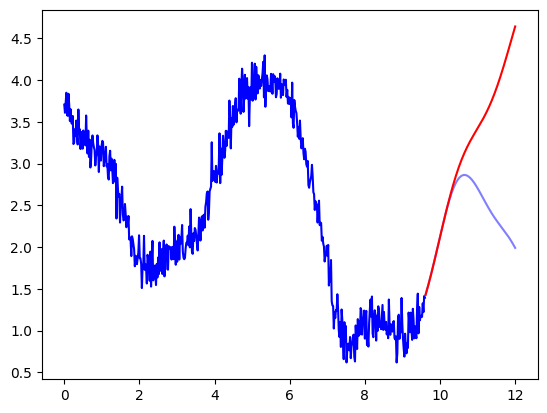

In [340]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
obs_grid = "0.00000 0.01878 0.03756 0.05634 0.07512 0.09390 0.11268 0.13146 0.15023 0.16901 0.18779 0.20657 0.22535 0.24413 0.26291 0.28169 0.30047 0.31925 0.33803 0.35681 0.37559 0.39437 0.41315 0.43192 0.45070 0.46948 0.48826 0.50704 0.52582 0.54460 0.56338 0.58216 0.60094 0.61972 0.63850 0.65728 0.67606 0.69484 0.71362 0.73239 0.75117 0.76995 0.78873 0.80751 0.82629 0.84507 0.86385 0.88263 0.90141 0.92019 0.93897 0.95775 0.97653 0.99531 1.01408 1.03286 1.05164 1.07042 1.08920 1.10798 1.12676 1.14554 1.16432 1.18310 1.20188 1.22066 1.23944 1.25822 1.27700 1.29577 1.31455 1.33333 1.35211 1.37089 1.38967 1.40845 1.42723 1.44601 1.46479 1.48357 1.50235 1.52113 1.53991 1.55869 1.57746 1.59624 1.61502 1.63380 1.65258 1.67136 1.69014 1.70892 1.72770 1.74648 1.76526 1.78404 1.80282 1.82160 1.84038 1.85915 1.87793 1.89671 1.91549 1.93427 1.95305 1.97183 1.99061 2.00939 2.02817 2.04695 2.06573 2.08451 2.10329 2.12207 2.14085 2.15962 2.17840 2.19718 2.21596 2.23474 2.25352 2.27230 2.29108 2.30986 2.32864 2.34742 2.36620 2.38498 2.40376 2.42254 2.44131 2.46009 2.47887 2.49765 2.51643 2.53521 2.55399 2.57277 2.59155 2.61033 2.62911 2.64789 2.66667 2.68545 2.70423 2.72300 2.74178 2.76056 2.77934 2.79812 2.81690 2.83568 2.85446 2.87324 2.89202 2.91080 2.92958 2.94836 2.96714 2.98592 3.00469 3.02347 3.04225 3.06103 3.07981 3.09859 3.11737 3.13615 3.15493 3.17371 3.19249 3.21127 3.23005 3.24883 3.26761 3.28638 3.30516 3.32394 3.34272 3.36150 3.38028 3.39906 3.41784 3.43662 3.45540 3.47418 3.49296 3.51174 3.53052 3.54930 3.56808 3.58685 3.60563 3.62441 3.64319 3.66197 3.68075 3.69953 3.71831 3.73709 3.75587 3.77465 3.79343 3.81221 3.83099 3.84977 3.86854 3.88732 3.90610 3.92488 3.94366 3.96244 3.98122 4.00000 4.01878 4.03756 4.05634 4.07512 4.09390 4.11268 4.13146 4.15023 4.16901 4.18779 4.20657 4.22535 4.24413 4.26291 4.28169 4.30047 4.31925 4.33803 4.35681 4.37559 4.39437 4.41315 4.43192 4.45070 4.46948 4.48826 4.50704 4.52582 4.54460 4.56338 4.58216 4.60094 4.61972 4.63850 4.65728 4.67606 4.69484 4.71362 4.73239 4.75117 4.76995 4.78873 4.80751 4.82629 4.84507 4.86385 4.88263 4.90141 4.92019 4.93897 4.95775 4.97653 4.99531 5.01408 5.03286 5.05164 5.07042 5.08920 5.10798 5.12676 5.14554 5.16432 5.18310 5.20188 5.22066 5.23944 5.25822 5.27700 5.29577 5.31455 5.33333 5.35211 5.37089 5.38967 5.40845 5.42723 5.44601 5.46479 5.48357 5.50235 5.52113 5.53991 5.55869 5.57746 5.59624 5.61502 5.63380 5.65258 5.67136 5.69014 5.70892 5.72770 5.74648 5.76526 5.78404 5.80282 5.82160 5.84038 5.85915 5.87793 5.89671 5.91549 5.93427 5.95305 5.97183 5.99061 6.00939 6.02817 6.04695 6.06573 6.08451 6.10329 6.12207 6.14085 6.15962 6.17840 6.19718 6.21596 6.23474 6.25352 6.27230 6.29108 6.30986 6.32864 6.34742 6.36620 6.38498 6.40376 6.42254 6.44131 6.46009 6.47887 6.49765 6.51643 6.53521 6.55399 6.57277 6.59155 6.61033 6.62911 6.64789 6.66667 6.68545 6.70423 6.72300 6.74178 6.76056 6.77934 6.79812 6.81690 6.83568 6.85446 6.87324 6.89202 6.91080 6.92958 6.94836 6.96714 6.98592 7.00469 7.02347 7.04225 7.06103 7.07981 7.09859 7.11737 7.13615 7.15493 7.17371 7.19249 7.21127 7.23005 7.24883 7.26761 7.28638 7.30516 7.32394 7.34272 7.36150 7.38028 7.39906 7.41784 7.43662 7.45540 7.47418 7.49296 7.51174 7.53052 7.54930 7.56808 7.58685 7.60563 7.62441 7.64319 7.66197 7.68075 7.69953 7.71831 7.73709 7.75587 7.77465 7.79343 7.81221 7.83099 7.84977 7.86854 7.88732 7.90610 7.92488 7.94366 7.96244 7.98122 8.00000 8.01878 8.03756 8.05634 8.07512 8.09390 8.11268 8.13146 8.15023 8.16901 8.18779 8.20657 8.22535 8.24413 8.26291 8.28169 8.30047 8.31925 8.33803 8.35681 8.37559 8.39437 8.41315 8.43192 8.45070 8.46948 8.48826 8.50704 8.52582 8.54460 8.56338 8.58216 8.60094 8.61972 8.63850 8.65728 8.67606 8.69484 8.71362 8.73239 8.75117 8.76995 8.78873 8.80751 8.82629 8.84507 8.86385 8.88263 8.90141 8.92019 8.93897 8.95775 8.97653 8.99531 9.01408 9.03286 9.05164 9.07042 9.08920 9.10798 9.12676 9.14554 9.16432 9.18310 9.20188 9.22066 9.23944 9.25822 9.27700 9.29577 9.31455 9.33333 9.35211 9.37089 9.38967 9.40845 9.42723 9.44601 9.46479 9.48357 9.50235 9.52113 9.53991 9.55869 9.57746 9.59624"
obs_values_noisy = "3.70503 3.60707 3.72105 3.84729 3.57756 3.57040 3.83429 3.70353 3.50821 3.64950 3.48744 3.47537 3.56930 3.23338 3.24866 3.40983 3.32883 3.51436 3.31744 3.22824 3.64646 3.37941 3.41026 3.17352 3.29296 3.37897 3.17776 3.39522 3.23763 3.27326 3.21648 3.57473 3.28544 3.11981 3.39326 3.07854 3.28514 2.95233 3.03980 3.26154 3.33596 3.24422 3.19457 3.16018 2.97696 3.08406 3.11608 3.33665 3.22224 2.89851 3.20343 3.08843 3.03549 3.21902 3.27153 3.24548 2.96808 3.03498 3.11764 3.20003 2.96670 2.99472 2.83972 2.80843 3.09102 3.15295 2.91818 3.05810 2.93953 2.76538 2.89240 3.04415 2.78256 2.99642 2.34186 2.83059 2.69226 2.60572 2.63523 2.29380 2.52909 2.58541 2.72308 2.39303 2.31875 2.33395 2.51572 2.39699 2.23761 2.36366 2.27108 2.37199 2.09194 2.11911 2.08095 1.89232 2.12897 2.09711 2.03285 1.97183 1.77050 1.89639 1.88571 1.79541 1.87124 1.93679 2.14099 1.86728 1.86394 1.79957 1.50959 1.78134 1.78354 2.13444 1.72784 1.79493 1.73876 1.56419 1.90767 1.84700 1.85200 1.59722 1.94541 1.52713 1.82884 2.07372 1.60177 1.67142 1.77804 1.69497 1.54586 1.79721 1.63646 1.87606 1.67658 2.05662 1.71638 1.79531 1.97534 1.67825 1.90636 2.07743 1.64902 1.92627 1.94557 2.03143 1.73570 1.72976 2.01219 1.98399 1.98203 2.00092 1.85094 1.99129 2.00346 1.85498 2.24424 2.03737 1.78924 2.06782 1.82438 2.08979 2.14662 1.85086 2.11970 2.03850 2.10151 2.26464 1.94559 1.87204 1.85486 1.86963 1.98474 2.05242 2.04837 2.13727 2.02222 2.24615 1.99707 2.45426 2.15039 1.93910 1.91902 2.16486 2.07264 2.22777 2.20699 2.14123 2.04210 1.95963 2.13839 2.35309 2.27674 2.07846 2.31269 2.36658 2.19891 2.37788 2.38750 2.23185 2.48205 2.53814 2.64263 2.66491 2.32733 2.42091 2.66689 2.69516 2.72421 3.25409 2.79139 2.90598 2.90893 2.89398 2.77966 2.97167 2.77295 2.88452 2.87850 2.99491 3.36117 2.76520 3.17948 2.86578 3.06790 3.33285 3.20974 3.06875 3.15313 3.39202 3.20981 3.38069 3.38347 3.30681 3.75355 3.55391 3.18135 3.53880 3.43666 3.68826 3.46535 3.59019 3.70565 3.78159 3.49283 3.64315 3.64183 3.63413 4.01530 3.82889 3.59596 3.93901 4.13520 3.98659 3.61795 3.78666 4.06206 3.77792 3.96198 4.02225 3.77697 3.91635 3.44767 3.78810 3.91109 3.76836 4.20629 3.75215 3.90526 3.99486 4.19481 3.76601 4.15807 3.98678 3.83914 4.05630 4.01700 3.89681 3.99660 3.92723 4.00061 4.08114 4.21767 3.79179 4.29489 3.67939 3.94655 4.05453 4.00527 3.86645 3.92528 3.87912 3.86115 4.07342 3.99586 3.83462 4.06964 3.97681 4.04851 4.01672 3.79340 3.82895 4.02000 3.99406 3.89358 3.90809 4.07543 3.78780 3.95077 3.82991 3.81843 4.00602 3.95436 3.94111 4.00259 3.79672 3.88176 3.71790 3.79708 3.71200 3.72817 3.78402 3.55219 3.96799 3.48150 3.42762 3.75989 3.68047 3.63002 3.60449 3.48143 3.32092 3.43836 3.29616 3.51404 3.31506 3.18197 3.22562 3.30317 3.12345 3.05085 3.17631 3.14148 2.99308 2.96227 3.03093 2.74152 2.70963 2.77439 2.81095 2.84979 2.98404 2.85034 2.65605 2.63492 2.44452 2.54865 2.46406 2.51114 2.29346 2.44974 2.55554 2.26265 2.29214 2.28794 2.07645 2.12219 2.04220 2.00655 1.82746 1.89860 1.92121 2.01593 1.89413 2.02552 1.54017 1.73935 1.58983 1.84533 1.35092 1.30240 1.29562 1.02517 1.22429 1.14992 1.24831 1.24039 1.43543 1.26300 1.00197 0.92350 1.10357 0.80507 1.25300 1.13227 0.86396 0.65829 1.10122 0.86580 1.05546 0.61938 0.75932 0.84260 0.84333 0.76506 0.92406 0.67027 0.81048 0.85289 0.91652 0.95201 0.68382 0.63087 1.06223 0.93105 0.78047 1.13777 0.93551 1.10870 0.95607 1.26956 1.23852 0.95280 1.15086 1.11686 1.24013 0.90464 1.16650 1.23615 0.82686 0.92590 0.80958 1.08641 1.24504 1.37252 1.16717 1.40833 0.96404 0.92160 1.17381 1.24378 1.18426 0.88100 1.17867 0.99625 1.29125 1.24367 1.04461 1.10448 1.01774 1.16143 1.30749 1.00898 1.22436 1.06048 1.01177 1.10482 0.95531 1.01691 0.90935 1.37260 1.07190 0.95033 1.07609 1.01597 0.98869 1.10324 1.11438 0.91125 0.89502 0.93126 0.61900 0.72948 1.15501 1.19075 0.90154 1.02116 0.97809 1.39093 1.09572 0.90831 0.78492 0.68908 0.96343 0.82339 0.72849 0.85089 0.79274 1.21618 1.10453 0.98127 1.21564 1.01741 0.88974 1.26146 1.12882 0.90829 1.05210 0.96696 0.90938 1.27506 1.44270 0.96747 1.28345 1.12395 1.17179 1.18007 1.16416 1.32661 1.22100 1.41324 1.39288"
obs_values_clean = "3.63052 3.62781 3.62390 3.61883 3.61268 3.60552 3.59741 3.58842 3.57863 3.56812 3.55696 3.54522 3.53300 3.52037 3.50740 3.49417 3.48075 3.46722 3.45364 3.44009 3.42661 3.41327 3.40013 3.38723 3.37462 3.36233 3.35041 3.33886 3.32773 3.31701 3.30673 3.29688 3.28747 3.27847 3.26988 3.26167 3.25381 3.24628 3.23903 3.23201 3.22519 3.21851 3.21192 3.20534 3.19874 3.19204 3.18517 3.17808 3.17070 3.16297 3.15482 3.14619 3.13703 3.12727 3.11688 3.10579 3.09396 3.08136 3.06795 3.05369 3.03858 3.02257 3.00567 2.98786 2.96914 2.94951 2.92899 2.90757 2.88528 2.86215 2.83819 2.81344 2.78794 2.76172 2.73483 2.70730 2.67920 2.65057 2.62146 2.59193 2.56204 2.53184 2.50140 2.47077 2.44002 2.40922 2.37841 2.34768 2.31708 2.28667 2.25652 2.22669 2.19725 2.16825 2.13977 2.11185 2.08456 2.05795 2.03208 2.00702 1.98280 1.95949 1.93712 1.91575 1.89543 1.87619 1.85806 1.84109 1.82531 1.81074 1.79740 1.78532 1.77450 1.76496 1.75669 1.74970 1.74397 1.73949 1.73625 1.73421 1.73335 1.73362 1.73499 1.73741 1.74081 1.74515 1.75035 1.75636 1.76310 1.77049 1.77846 1.78692 1.79580 1.80502 1.81449 1.82413 1.83387 1.84362 1.85332 1.86288 1.87225 1.88135 1.89015 1.89857 1.90659 1.91416 1.92125 1.92783 1.93390 1.93944 1.94446 1.94895 1.95294 1.95645 1.95950 1.96213 1.96438 1.96630 1.96793 1.96934 1.97059 1.97173 1.97283 1.97396 1.97519 1.97658 1.97821 1.98012 1.98240 1.98510 1.98829 1.99200 1.99631 2.00125 2.00686 2.01319 2.02027 2.02812 2.03677 2.04624 2.05654 2.06767 2.07966 2.09249 2.10616 2.12067 2.13601 2.15216 2.16911 2.18686 2.20537 2.22463 2.24462 2.26532 2.28672 2.30878 2.33149 2.35482 2.37876 2.40329 2.42838 2.45402 2.48018 2.50684 2.53398 2.56159 2.58963 2.61810 2.64695 2.67618 2.70575 2.73565 2.76583 2.79627 2.82695 2.85783 2.88887 2.92004 2.95131 2.98263 3.01397 3.04529 3.07654 3.10769 3.13869 3.16951 3.20009 3.23041 3.26042 3.29009 3.31936 3.34822 3.37663 3.40455 3.43196 3.45882 3.48512 3.51083 3.53593 3.56040 3.58423 3.60740 3.62990 3.65173 3.67287 3.69332 3.71308 3.73213 3.75049 3.76814 3.78509 3.80133 3.81688 3.83172 3.84585 3.85929 3.87203 3.88407 3.89541 3.90606 3.91601 3.92528 3.93386 3.94175 3.94898 3.95553 3.96142 3.96667 3.97127 3.97525 3.97862 3.98139 3.98359 3.98524 3.98637 3.98699 3.98714 3.98684 3.98613 3.98503 3.98359 3.98182 3.97977 3.97746 3.97493 3.97221 3.96932 3.96628 3.96312 3.95986 3.95650 3.95307 3.94956 3.94597 3.94231 3.93856 3.93470 3.93072 3.92659 3.92227 3.91775 3.91298 3.90791 3.90250 3.89671 3.89049 3.88378 3.87653 3.86870 3.86023 3.85108 3.84120 3.83055 3.81908 3.80677 3.79357 3.77947 3.76444 3.74846 3.73152 3.71362 3.69475 3.67492 3.65413 3.63240 3.60974 3.58618 3.56172 3.53640 3.51024 3.48327 3.45551 3.42699 3.39773 3.36777 3.33711 3.30580 3.27383 3.24123 3.20801 3.17418 3.13976 3.10474 3.06912 3.03292 2.99613 2.95874 2.92075 2.88216 2.84296 2.80316 2.76273 2.72170 2.68004 2.63778 2.59490 2.55142 2.50736 2.46273 2.41754 2.37184 2.32563 2.27897 2.23188 2.18442 2.13663 2.08858 2.04031 1.99190 1.94342 1.89493 1.84651 1.79825 1.75024 1.70254 1.65527 1.60850 1.56233 1.51685 1.47217 1.42836 1.38553 1.34376 1.30315 1.26379 1.22575 1.18913 1.15400 1.12043 1.08850 1.05827 1.02978 1.00311 0.97829 0.95535 0.93433 0.91526 0.89814 0.88298 0.86979 0.85854 0.84923 0.84182 0.83628 0.83257 0.83063 0.83041 0.83184 0.83485 0.83935 0.84527 0.85251 0.86098 0.87058 0.88120 0.89275 0.90510 0.91816 0.93181 0.94594 0.96045 0.97522 0.99014 1.00512 1.02005 1.03484 1.04938 1.06359 1.07738 1.09067 1.10339 1.11546 1.12682 1.13741 1.14717 1.15606 1.16403 1.17106 1.17710 1.18215 1.18617 1.18916 1.19111 1.19203 1.19192 1.19080 1.18868 1.18559 1.18156 1.17663 1.17083 1.16422 1.15684 1.14875 1.14002 1.13070 1.12087 1.11060 1.09996 1.08903 1.07789 1.06661 1.05529 1.04400 1.03282 1.02183 1.01112 1.00076 0.99082 0.98139 0.97252 0.96429 0.95676 0.94998 0.94401 0.93889 0.93468 0.93140 0.92909 0.92779 0.92750 0.92825 0.93005 0.93291 0.93684 0.94183 0.94787 0.95497 0.96311 0.97228 0.98246 0.99365 1.00581 1.01893 1.03300 1.04798 1.06388 1.08066 1.09830 1.11680 1.13613 1.15629 1.17725 1.19901 1.22155 1.24486 1.26893 1.29376 1.31933 1.34564 1.37267 1.40042"
obs_mask = "True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True"
target_grid = "9.61502 9.63380 9.65258 9.67136 9.69014 9.70892 9.72770 9.74648 9.76526 9.78404 9.80282 9.82160 9.84038 9.85915 9.87793 9.89671 9.91549 9.93427 9.95305 9.97183 9.99061 10.00939 10.02817 10.04695 10.06573 10.08451 10.10329 10.12207 10.14085 10.15962 10.17840 10.19718 10.21596 10.23474 10.25352 10.27230 10.29108 10.30986 10.32864 10.34742 10.36620 10.38498 10.40376 10.42254 10.44131 10.46009 10.47887 10.49765 10.51643 10.53521 10.55399 10.57277 10.59155 10.61033 10.62911 10.64789 10.66667 10.68545 10.70423 10.72300 10.74178 10.76056 10.77934 10.79812 10.81690 10.83568 10.85446 10.87324 10.89202 10.91080 10.92958 10.94836 10.96714 10.98592 11.00469 11.02347 11.04225 11.06103 11.07981 11.09859 11.11737 11.13615 11.15493 11.17371 11.19249 11.21127 11.23005 11.24883 11.26761 11.28638 11.30516 11.32394 11.34272 11.36150 11.38028 11.39906 11.41784 11.43662 11.45540 11.47418 11.49296 11.51174 11.53052 11.54930 11.56808 11.58685 11.60563 11.62441 11.64319 11.66197 11.68075 11.69953 11.71831 11.73709 11.75587 11.77465 11.79343 11.81221 11.83099 11.84977 11.86854 11.88732 11.90610 11.92488 11.94366 11.96244 11.98122 12.00000"
target_values = "1.42887 1.45801 1.48783 1.51830 1.54943 1.58117 1.61351 1.64642 1.67987 1.71383 1.74827 1.78313 1.81839 1.85398 1.88987 1.92599 1.96229 1.99872 2.03520 2.07168 2.10808 2.14434 2.18039 2.21616 2.25156 2.28654 2.32102 2.35492 2.38818 2.42072 2.45248 2.48339 2.51338 2.54240 2.57039 2.59729 2.62306 2.64764 2.67100 2.69310 2.71391 2.73339 2.75153 2.76831 2.78371 2.79773 2.81037 2.82162 2.83149 2.83999 2.84714 2.85296 2.85746 2.86068 2.86264 2.86338 2.86293 2.86133 2.85861 2.85483 2.85001 2.84421 2.83747 2.82984 2.82136 2.81208 2.80205 2.79132 2.77994 2.76795 2.75541 2.74236 2.72884 2.71492 2.70063 2.68602 2.67114 2.65603 2.64074 2.62530 2.60978 2.59419 2.57858 2.56300 2.54747 2.53203 2.51670 2.50153 2.48652 2.47172 2.45713 2.44277 2.42866 2.41481 2.40121 2.38789 2.37483 2.36202 2.34948 2.33717 2.32509 2.31322 2.30154 2.29003 2.27866 2.26740 2.25623 2.24512 2.23403 2.22293 2.21179 2.20058 2.18926 2.17780 2.16617 2.15435 2.14230 2.13000 2.11744 2.10457 2.09141 2.07792 2.06411 2.04997 2.03549 2.02070 2.00558 1.99017"

obs_grid = np.array(obs_grid.split(), dtype=float) 
obs_values_noisy = np.array(obs_values_noisy.split(), dtype=float) 
obs_values_clean = np.array(obs_values_clean.split(), dtype=float) 
obs_mask = np.array([val == "True" for val in obs_mask.split()], dtype=bool)
target_grid = np.array(target_grid.split(), dtype=float) 
target_values = np.array(target_values.split(), dtype=float) 
size = int(len(obs_values_clean) * 0.66)
#train, test = obs_values_clean[0:size], obs_values_clean[size:len(obs_values_clean)]
train, test = obs_values_clean, target_values
history = [x for x in train]
print(history)
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model.initialize_approximate_diffuse()
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(output[0])
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

plt.plot(obs_grid, obs_values_noisy, color='blue')
plt.plot(target_grid, target_values, color='blue', alpha=0.5)
plt.plot(target_grid, predictions, color='red')

Optimal ARIMA parameters: (0, 0, 0)


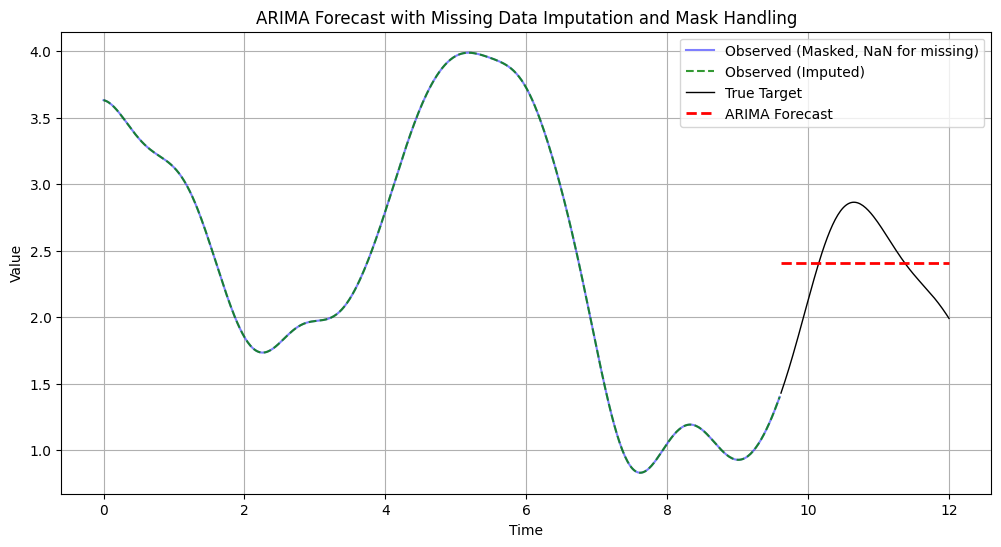

Mean Squared Error on the target range: 0.14400167538024333


In [ ]:
obs_grid = "0.00000 0.01565 0.03130 0.04695 0.06260 0.07825 0.09390 0.10955 0.12520  0.14085 0.15649 0.17214 0.18779 0.20344 0.21909 0.23474 0.25039 0.26604  0.28169 0.29734 0.31299 0.32864 0.34429 0.35994 0.37559 0.39124 0.40689  0.42254 0.43818 0.45383 0.46948 0.48513 0.50078 0.51643 0.53208 0.54773  0.56338 0.57903 0.59468 0.61033 0.62598 0.64163 0.65728 0.67293 0.68858  0.70423 0.71987 0.73552 0.75117 0.76682 0.78247 0.79812 0.81377 0.82942  0.84507 0.86072 0.87637 0.89202 0.90767 0.92332 0.93897 0.95462 0.97027  0.98592 1.00156 1.01721 1.03286 1.04851 1.06416 1.07981 1.09546 1.11111  1.12676 1.14241 1.15806 1.17371 1.18936 1.20501 1.22066 1.23631 1.25196  1.26761 1.28326 1.29890 1.31455 1.33020 1.34585 1.36150 1.37715 1.39280  1.40845 1.42410 1.43975 1.45540 1.47105 1.48670 1.50235 1.51800 1.53365  1.54930 1.56495 1.58059 1.59624 1.61189 1.62754 1.64319 1.65884 1.67449  1.69014 1.70579 1.72144 1.73709 1.75274 1.76839 1.78404 1.79969 1.81534  1.83099 1.84664 1.86228 1.87793 1.89358 1.90923 1.92488 1.94053 1.95618  1.97183 1.98748 2.00313 2.01878 2.03443 2.05008 2.06573 2.08138 2.09703  2.11268 2.12833 2.14397 2.15962 2.17527 2.19092 2.20657 2.22222 2.23787  2.25352 2.26917 2.28482 2.30047 2.31612 2.33177 2.34742 2.36307 2.37872  2.39437 2.41002 2.42567 2.44131 2.45696 2.47261 2.48826 2.50391 2.51956  2.53521 2.55086 2.56651 2.58216 2.59781 2.61346 2.62911 2.64476 2.66041  2.67606 2.69171 2.70736 2.72300 2.73865 2.75430 2.76995 2.78560 2.80125  2.81690 2.83255 2.84820 2.86385 2.87950 2.89515 2.91080 2.92645 2.94210  2.95775 2.97340 2.98905 3.00469 3.02034 3.03599 3.05164 3.06729 3.08294  3.09859 3.11424 3.12989 3.14554 3.16119 3.17684 3.19249 3.20814 3.22379  3.23944 3.25509 3.27074 3.28638 3.30203 3.31768 3.33333 3.34898 3.36463  3.38028 3.39593 3.41158 3.42723 3.44288 3.45853 3.47418 3.48983 3.50548  3.52113 3.53678 3.55243 3.56808 3.58372 3.59937 3.61502 3.63067 3.64632  3.66197 3.67762 3.69327 3.70892 3.72457 3.74022 3.75587 3.77152 3.78717  3.80282 3.81847 3.83412 3.84977 3.86541 3.88106 3.89671 3.91236 3.92801  3.94366 3.95931 3.97496 3.99061 4.00626 4.02191 4.03756 4.05321 4.06886  4.08451 4.10016 4.11581 4.13146 4.14710 4.16275 4.17840 4.19405 4.20970  4.22535 4.24100 4.25665 4.27230 4.28795 4.30360 4.31925 4.33490 4.35055  4.36620 4.38185 4.39750 4.41315 4.42879 4.44444 4.46009 4.47574 4.49139  4.50704 4.52269 4.53834 4.55399 4.56964 4.58529 4.60094 4.61659 4.63224  4.64789 4.66354 4.67919 4.69484 4.71049 4.72613 4.74178 4.75743 4.77308  4.78873 4.80438 4.82003 4.83568 4.85133 4.86698 4.88263 4.89828 4.91393  4.92958 4.94523 4.96088 4.97653 4.99218 5.00782 5.02347 5.03912 5.05477  5.07042 5.08607 5.10172 5.11737 5.13302 5.14867 5.16432 5.17997 5.19562  5.21127 5.22692 5.24257 5.25822 5.27387 5.28951 5.30516 5.32081 5.33646  5.35211 5.36776 5.38341 5.39906 5.41471 5.43036 5.44601 5.46166 5.47731  5.49296 5.50861 5.52426 5.53991 5.55556 5.57121 5.58685 5.60250 5.61815  5.63380 5.64945 5.66510 5.68075 5.69640 5.71205 5.72770 5.74335 5.75900  5.77465 5.79030 5.80595 5.82160 5.83725 5.85290 5.86854 5.88419 5.89984  5.91549 5.93114 5.94679 5.96244 5.97809 5.99374 6.00939 6.02504 6.04069  6.05634 6.07199 6.08764 6.10329 6.11894 6.13459 6.15023 6.16588 6.18153  6.19718 6.21283 6.22848 6.24413 6.25978 6.27543 6.29108 6.30673 6.32238  6.33803 6.35368 6.36933 6.38498 6.40063 6.41628 6.43192 6.44757 6.46322  6.47887 6.49452 6.51017 6.52582 6.54147 6.55712 6.57277 6.58842 6.60407  6.61972 6.63537 6.65102 6.66667 6.68232 6.69797 6.71362 6.72926 6.74491  6.76056 6.77621 6.79186 6.80751 6.82316 6.83881 6.85446 6.87011 6.88576  6.90141 6.91706 6.93271 6.94836 6.96401 6.97966 6.99531 7.01095 7.02660  7.04225 7.05790 7.07355 7.08920 7.10485 7.12050 7.13615 7.15180 7.16745  7.18310 7.19875 7.21440 7.23005 7.24570 7.26135 7.27700 7.29264 7.30829  7.32394 7.33959 7.35524 7.37089 7.38654 7.40219 7.41784 7.43349 7.44914  7.46479 7.48044 7.49609 7.51174 7.52739 7.54304 7.55869 7.57433 7.58998  7.60563 7.62128 7.63693 7.65258 7.66823 7.68388 7.69953 7.71518 7.73083  7.74648 7.76213 7.77778 7.79343 7.80908 7.82473 7.84038 7.85603 7.87167  7.88732 7.90297 7.91862 7.93427 7.94992 7.96557 7.98122 7.99687"
obs_values_noisy = "0.75411 0.00000 1.14312 0.95870 0.00000 1.18365 0.00000 1.26275 1.26253  0.00000 1.20856 0.00000 1.21970 0.00000 1.32237 1.35528 0.00000 1.24423  1.34465 1.13002 0.00000 0.00000 1.46817 0.00000 1.25883 0.00000 0.00000  1.44328 0.00000 1.65813 0.00000 0.00000 1.54282 1.55527 0.00000 0.00000  1.45458 0.00000 0.00000 0.00000 0.00000 0.00000 1.83566 0.00000 1.69699  0.00000 1.81898 0.00000 0.00000 0.00000 1.69908 1.82921 1.88260 0.00000  1.80295 1.93540 0.00000 0.00000 1.91974 0.00000 1.97754 0.00000 0.00000  1.99927 1.89972 0.00000 0.00000 0.00000 2.28669 0.00000 0.00000 2.23827  0.00000 0.00000 2.13323 0.00000 2.18293 0.00000 0.00000 2.18195 0.00000  0.00000 2.38010 0.00000 2.32457 2.42906 0.00000 0.00000 2.48326 0.00000  2.51718 2.55036 2.55621 0.00000 2.48169 2.43845 0.00000 0.00000 0.00000  0.00000 0.00000 2.74607 2.60399 0.00000 0.00000 2.64636 2.68172 0.00000  2.84973 2.72006 0.00000 2.80464 2.83803 0.00000 2.94743 0.00000 2.77496  2.87085 0.00000 0.00000 0.00000 0.00000 2.98806 2.96690 3.05476 2.94826  0.00000 0.00000 0.00000 3.01135 0.00000 2.97786 0.00000 0.00000 0.00000  0.00000 0.00000 0.00000 0.00000 3.36407 0.00000 3.25576 3.20481 3.14299  0.00000 0.00000 3.42163 0.00000 3.33525 3.45898 0.00000 0.00000 0.00000  0.00000 3.45341 0.00000 3.46817 3.57263 3.42021 3.51490 0.00000 0.00000  3.61760 3.47111 0.00000 0.00000 0.00000 3.71681 3.82243 0.00000 0.00000  0.00000 0.00000 3.52026 3.72223 3.90331 3.77629 3.63514 0.00000 3.81673  0.00000 3.81763 3.97362 0.00000 0.00000 0.00000 0.00000 3.92871 3.93516  0.00000 4.02351 0.00000 3.91179 3.98842 4.09413 3.99529 4.13893 4.00976  0.00000 0.00000 0.00000 4.26195 0.00000 4.18158 0.00000 0.00000 4.34749  4.30710 4.26552 0.00000 0.00000 4.28842 0.00000 4.33595 4.21607 4.27545  4.58056 0.00000 4.55033 4.41717 0.00000 4.32563 0.00000 4.45269 4.68847  0.00000 0.00000 4.44733 0.00000 0.00000 4.71488 0.00000 4.57965 4.73404  4.62918 0.00000 0.00000 0.00000 0.00000 4.89184 0.00000 0.00000 4.76170  0.00000 4.85447 5.02922 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000  0.00000 0.00000 4.94178 0.00000 0.00000 4.99027 5.09375 4.96195 4.97452  5.10156 5.08607 5.08261 5.39328 0.00000 0.00000 5.10636 5.14955 0.00000  0.00000 5.23328 5.30603 0.00000 0.00000 0.00000 0.00000 0.00000 5.20134  0.00000 0.00000 5.26361 0.00000 5.53161 5.38501 5.44168 0.00000 5.39121  5.52965 0.00000 5.41306 0.00000 0.00000 5.60602 5.56463 5.76150 0.00000  5.77406 0.00000 0.00000 0.00000 0.00000 5.76347 0.00000 0.00000 5.74801  0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 5.88691 0.00000 0.00000  5.94084 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000  5.93735 5.99699 6.05353 6.22634 6.03999 0.00000 6.09064 0.00000 6.21723  0.00000 0.00000 0.00000 0.00000 6.25179 6.20150 6.31067 6.34724 6.50473  0.00000 0.00000 0.00000 6.57074 0.00000 6.23390 6.41075 6.58386 6.65182  0.00000 6.54168 6.63279 6.43036 0.00000 0.00000 0.00000 6.54785 6.69989  6.55588 0.00000 0.00000 0.00000 6.67695 6.90903 6.79501 0.00000 0.00000  0.00000 0.00000 6.81448 0.00000 6.74816 6.93870 0.00000 0.00000 0.00000  0.00000 7.01398 0.00000 0.00000 6.89976 0.00000 0.00000 7.07014 7.28865  0.00000 7.02545 0.00000 0.00000 7.32295 7.21726 7.25662 7.29295 6.96701  7.35008 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 7.36643  7.50055 0.00000 7.57550 0.00000 0.00000 0.00000 7.47367 0.00000 0.00000  7.56792 7.37395 0.00000 7.80441 7.61265 0.00000 0.00000 0.00000 0.00000  0.00000 0.00000 0.00000 7.51999 0.00000 7.79251 7.66879 7.73320 7.79966  0.00000 0.00000 0.00000 7.85074 0.00000 0.00000 7.82060 7.94197 7.97459  7.88832 0.00000 0.00000 0.00000 7.96362 8.01410 0.00000 0.00000 0.00000  0.00000 0.00000 8.01292 0.00000 0.00000 0.00000 8.03627 8.17436 0.00000  0.00000 0.00000 0.00000 0.00000 0.00000 8.22454 8.27353 0.00000 8.20322  8.43191 0.00000 8.41054 0.00000 0.00000 0.00000 8.37962 0.00000 8.43858  8.23645 8.56728 8.48979 0.00000 8.58880 0.00000 8.46067 8.56696 8.56156  8.56657 0.00000 8.61156 8.71199 8.47215 8.70846 0.00000 8.76458 0.00000  8.83236 8.56194 8.67701 8.72159 8.72472 0.00000 8.78994 0.00000 8.96732  0.00000 0.00000 0.00000 0.00000 0.00000 8.78980 0.00000 0.00000"
obs_values_clean = "1.00000 1.01565 1.03130 1.04695 1.06260 1.07825 1.09390 1.10955 1.12520  1.14085 1.15649 1.17214 1.18779 1.20344 1.21909 1.23474 1.25039 1.26604  1.28169 1.29734 1.31299 1.32864 1.34429 1.35994 1.37559 1.39124 1.40689  1.42254 1.43818 1.45383 1.46948 1.48513 1.50078 1.51643 1.53208 1.54773  1.56338 1.57903 1.59468 1.61033 1.62598 1.64163 1.65728 1.67293 1.68858  1.70423 1.71987 1.73552 1.75117 1.76682 1.78247 1.79812 1.81377 1.82942  1.84507 1.86072 1.87637 1.89202 1.90767 1.92332 1.93897 1.95462 1.97027  1.98592 2.00156 2.01721 2.03286 2.04851 2.06416 2.07981 2.09546 2.11111  2.12676 2.14241 2.15806 2.17371 2.18936 2.20501 2.22066 2.23631 2.25196  2.26761 2.28326 2.29890 2.31455 2.33020 2.34585 2.36150 2.37715 2.39280  2.40845 2.42410 2.43975 2.45540 2.47105 2.48670 2.50235 2.51800 2.53365  2.54930 2.56495 2.58059 2.59624 2.61189 2.62754 2.64319 2.65884 2.67449  2.69014 2.70579 2.72144 2.73709 2.75274 2.76839 2.78404 2.79969 2.81534  2.83099 2.84664 2.86228 2.87793 2.89358 2.90923 2.92488 2.94053 2.95618  2.97183 2.98748 3.00313 3.01878 3.03443 3.05008 3.06573 3.08138 3.09703  3.11268 3.12833 3.14397 3.15962 3.17527 3.19092 3.20657 3.22222 3.23787  3.25352 3.26917 3.28482 3.30047 3.31612 3.33177 3.34742 3.36307 3.37872  3.39437 3.41002 3.42567 3.44131 3.45696 3.47261 3.48826 3.50391 3.51956  3.53521 3.55086 3.56651 3.58216 3.59781 3.61346 3.62911 3.64476 3.66041  3.67606 3.69171 3.70736 3.72300 3.73865 3.75430 3.76995 3.78560 3.80125  3.81690 3.83255 3.84820 3.86385 3.87950 3.89515 3.91080 3.92645 3.94210  3.95775 3.97340 3.98905 4.00469 4.02034 4.03599 4.05164 4.06729 4.08294  4.09859 4.11424 4.12989 4.14554 4.16119 4.17684 4.19249 4.20814 4.22379  4.23944 4.25509 4.27074 4.28638 4.30203 4.31768 4.33333 4.34898 4.36463  4.38028 4.39593 4.41158 4.42723 4.44288 4.45853 4.47418 4.48983 4.50548  4.52113 4.53678 4.55243 4.56808 4.58372 4.59937 4.61502 4.63067 4.64632  4.66197 4.67762 4.69327 4.70892 4.72457 4.74022 4.75587 4.77152 4.78717  4.80282 4.81847 4.83412 4.84977 4.86541 4.88106 4.89671 4.91236 4.92801  4.94366 4.95931 4.97496 4.99061 5.00626 5.02191 5.03756 5.05321 5.06886  5.08451 5.10016 5.11581 5.13146 5.14710 5.16275 5.17840 5.19405 5.20970  5.22535 5.24100 5.25665 5.27230 5.28795 5.30360 5.31925 5.33490 5.35055  5.36620 5.38185 5.39750 5.41315 5.42879 5.44444 5.46009 5.47574 5.49139  5.50704 5.52269 5.53834 5.55399 5.56964 5.58529 5.60094 5.61659 5.63224  5.64789 5.66354 5.67919 5.69484 5.71049 5.72613 5.74178 5.75743 5.77308  5.78873 5.80438 5.82003 5.83568 5.85133 5.86698 5.88263 5.89828 5.91393  5.92958 5.94523 5.96088 5.97653 5.99218 6.00782 6.02347 6.03912 6.05477  6.07042 6.08607 6.10172 6.11737 6.13302 6.14867 6.16432 6.17997 6.19562  6.21127 6.22692 6.24257 6.25822 6.27387 6.28951 6.30516 6.32081 6.33646  6.35211 6.36776 6.38341 6.39906 6.41471 6.43036 6.44601 6.46166 6.47731  6.49296 6.50861 6.52426 6.53991 6.55556 6.57121 6.58685 6.60250 6.61815  6.63380 6.64945 6.66510 6.68075 6.69640 6.71205 6.72770 6.74335 6.75900  6.77465 6.79030 6.80595 6.82160 6.83725 6.85290 6.86854 6.88419 6.89984  6.91549 6.93114 6.94679 6.96244 6.97809 6.99374 7.00939 7.02504 7.04069  7.05634 7.07199 7.08764 7.10329 7.11894 7.13459 7.15023 7.16588 7.18153  7.19718 7.21283 7.22848 7.24413 7.25978 7.27543 7.29108 7.30673 7.32238  7.33803 7.35368 7.36933 7.38498 7.40063 7.41628 7.43192 7.44757 7.46322  7.47887 7.49452 7.51017 7.52582 7.54147 7.55712 7.57277 7.58842 7.60407  7.61972 7.63537 7.65102 7.66667 7.68232 7.69797 7.71362 7.72926 7.74491  7.76056 7.77621 7.79186 7.80751 7.82316 7.83881 7.85446 7.87011 7.88576  7.90141 7.91706 7.93271 7.94836 7.96401 7.97966 7.99531 8.01095 8.02660  8.04225 8.05790 8.07355 8.08920 8.10485 8.12050 8.13615 8.15180 8.16745  8.18310 8.19875 8.21440 8.23005 8.24570 8.26135 8.27700 8.29264 8.30829  8.32394 8.33959 8.35524 8.37089 8.38654 8.40219 8.41784 8.43349 8.44914  8.46479 8.48044 8.49609 8.51174 8.52739 8.54304 8.55869 8.57433 8.58998  8.60563 8.62128 8.63693 8.65258 8.66823 8.68388 8.69953 8.71518 8.73083  8.74648 8.76213 8.77778 8.79343 8.80908 8.82473 8.84038 8.85603 8.87167  8.88732 8.90297 8.91862 8.93427 8.94992 8.96557 8.98122 8.99687"
obs_mask = " True False  True  True False  True False  True  True False  True False   True False  True  True False  True  True  True False False  True False   True False False  True False  True False False  True  True False False   True False False False False False  True False  True False  True False  False False  True  True  True False  True  True False False  True False   True False False  True  True False False False  True False False  True  False False  True False  True False False  True False False  True False   True  True False False  True False  True  True  True False  True  True  False False False False False  True  True False False  True  True False   True  True False  True  True False  True False  True  True False False  False False  True  True  True  True False False False  True False  True  False False False False False False False  True False  True  True  True  False False  True False  True  True False False False False  True False   True  True  True  True False False  True  True False False False  True   True False False False False  True  True  True  True  True False  True  False  True  True False False False False  True  True False  True False   True  True  True  True  True  True False False False  True False  True  False False  True  True  True False False  True False  True  True  True   True False  True  True False  True False  True  True False False  True  False False  True False  True  True  True False False False False  True  False False  True False  True  True False False False False False False  False False  True False False  True  True  True  True  True  True  True   True False False  True  True False False  True  True False False False  False False  True False False  True False  True  True  True False  True   True False  True False False  True  True  True False  True False False  False False  True False False  True False False False False False False   True False False  True False False False False False False False False   True  True  True  True  True False  True False  True False False False  False  True  True  True  True  True False False False  True False  True   True  True  True False  True  True  True False False False  True  True   True False False False  True  True  True False False False False  True  False  True  True False False False False  True False False  True False  False  True  True False  True False False  True  True  True  True  True   True False False False False False False False  True  True False  True  False False False  True False False  True  True False  True  True False  False False False False False False  True False  True  True  True  True  False False False  True False False  True  True  True  True False False  False  True  True False False False False False  True False False False   True  True False False False False False False  True  True False  True   True False  True False False False  True False  True  True  True  True  False  True False  True  True  True  True False  True  True  True  True  False  True False  True  True  True  True  True False  True False  True  False False False False False  True False False"
target_grid = "8.01252 8.02817 8.04382 8.05947 8.07512 8.09077 8.10642 8.12207 8.13772  8.15336 8.16901 8.18466 8.20031 8.21596 8.23161 8.24726 8.26291 8.27856  8.29421 8.30986 8.32551 8.34116 8.35681 8.37246 8.38811 8.40376 8.41941  8.43505 8.45070 8.46635 8.48200 8.49765 8.51330 8.52895 8.54460 8.56025  8.57590 8.59155 8.60720 8.62285 8.63850 8.65415 8.66980 8.68545 8.70110  8.71674 8.73239 8.74804 8.76369 8.77934 8.79499 8.81064 8.82629 8.84194  8.85759 8.87324 8.88889 8.90454 8.92019 8.93584 8.95149 8.96714 8.98279  8.99844 9.01408 9.02973 9.04538 9.06103 9.07668 9.09233 9.10798 9.12363  9.13928 9.15493 9.17058 9.18623 9.20188 9.21753 9.23318 9.24883 9.26448  9.28013 9.29577 9.31142 9.32707 9.34272 9.35837 9.37402 9.38967 9.40532  9.42097 9.43662 9.45227 9.46792 9.48357 9.49922 9.51487 9.53052 9.54617  9.56182 9.57746 9.59311 9.60876 9.62441 9.64006 9.65571 9.67136 9.68701  9.70266 9.71831 9.73396 9.74961 9.76526 9.78091 9.79656 9.81221 9.82786  9.84351 9.85915 9.87480 9.89045 9.90610 9.92175 9.93740 9.95305 9.96870  9.98435 10.00000"
target_values = "9.01252 9.02817 9.04382 9.05947 9.07512 9.09077 9.10642 9.12207 9.13772  9.15336 9.16901 9.18466 9.20031 9.21596 9.23161 9.24726 9.26291 9.27856  9.29421 9.30986 9.32551 9.34116 9.35681 9.37246 9.38811 9.40376 9.41941  9.43505 9.45070 9.46635 9.48200 9.49765 9.51330 9.52895 9.54460 9.56025  9.57590 9.59155 9.60720 9.62285 9.63850 9.65415 9.66980 9.68545 9.70110  9.71674 9.73239 9.74804 9.76369 9.77934 9.79499 9.81064 9.82629 9.84194  9.85759 9.87324 9.88889 9.90454 9.92019 9.93584 9.95149 9.96714 9.98279  9.99844 10.01408 10.02973 10.04538 10.06103 10.07668 10.09233 10.10798  10.12363 10.13928 10.15493 10.17058 10.18623 10.20188 10.21753 10.23318  10.24883 10.26448 10.28013 10.29577 10.31142 10.32707 10.34272 10.35837  10.37402 10.38967 10.40532 10.42097 10.43662 10.45227 10.46792 10.48357  10.49922 10.51487 10.53052 10.54617 10.56182 10.57746 10.59311 10.60876  10.62441 10.64006 10.65571 10.67136 10.68701 10.70266 10.71831 10.73396  10.74961 10.76526 10.78091 10.79656 10.81221 10.82786 10.84351 10.85915  10.87480 10.89045 10.90610 10.92175 10.93740 10.95305 10.96870 10.98435  11.00000"

obs_grid = np.array(obs_grid.split(), dtype=float) 
obs_values_noisy = np.array(obs_values_noisy.split(), dtype=float) 
obs_values_clean = np.array(obs_values_clean.split(), dtype=float) 
obs_mask = np.array([val == "True" for val in obs_mask.split()], dtype=bool)
target_grid = np.array(target_grid.split(), dtype=float) 
target_values = np.array(target_values.split(), dtype=float) 

g_y_min, g_y_max = np.min(obs_values_noisy[obs_mask]), np.max(obs_values_noisy[obs_mask])
g_t_min, g_t_max = np.min(obs_grid[obs_mask]), np.max(obs_grid[obs_mask])


obs_values_noisy[obs_mask] = (obs_values_noisy[obs_mask] - g_y_min)/(g_y_max - g_y_min)
#obs_grid = (obs_values_noisy - g_t_min)/(g_t_max - g_t_min)

target_values = (target_values - g_y_min) / (g_y_max - g_y_min)

y = np.append(obs_values_noisy[obs_mask],target_values)

c = np.append(obs_grid[obs_mask],target_grid)
x = (c - np.min(c)) / (np.max(c) - np.min(c))

obs_grid[obs_mask] = (obs_grid[obs_mask]  - np.min(c)) / (np.max(c) - np.min(c))
target_grid = (target_grid - np.min(c)) / (np.max(c) - np.min(c))

plt.figure(figsize=(8, 4))
plt.scatter(x,y, color='green', label='Observation', s=10)

obs_grid = obs_grid.reshape(4,128)
obs_mask = obs_mask.reshape(4,128)
obs_values_noisy = obs_values_noisy.reshape(4,128)


obs_grid_model = np.zeros((4,128))
obs_mask_model = np.zeros((4,128))
obs_values_noisy_model = np.zeros((4,128))
stats = np.zeros((4,9))


target_grid_model = np.zeros((5,128))
target_grid_model[0] = np.linspace(0,1,128) # (target_grid - np.min(target_grid)) / (np.max(target_grid) - np.min(target_grid))
target_grid_model[1] = np.linspace(0,1,128)
target_grid_model[2] = np.linspace(0,1,128)
target_grid_model[3] = np.linspace(0,1,128)
target_grid_model[4] = np.linspace(0,1,128)


fim = FIML(d_model=256,heads=4)
fim.load_state_dict((torch.load("model_fim_l.pth")))
fim.to(device)
fim = torch.compile(fim)
fim.eval()

for i in range(obs_grid.shape[0]):
    obs_grid_i = obs_grid[i][obs_mask[i]]
    obs_values_noisy_i = obs_values_noisy[i][obs_mask[i]]

    y_min,y_max = np.min(obs_values_noisy_i),np.max(obs_values_noisy_i)
    t_min,t_max = np.min(obs_grid_i),np.max(obs_grid_i)

    a = (obs_values_noisy_i - y_min) / (y_max-y_min)
    b = (obs_grid_i - t_min) / (t_max-t_min)

    obs_values_noisy_model[i] = np.append( a,np.zeros(128 - len(obs_grid_i))) 
    obs_grid_model[i] =  np.append(b,np.zeros(128 - len(obs_grid_i)))
    obs_mask_model[i] =  np.append(np.ones(len(obs_grid_i)),np.zeros(128 - len(obs_grid_i)))    


    stats[i] = np.array([y_min,y_max,
                         y_max-y_min,
                         obs_values_noisy_i[0],obs_values_noisy_i[-1],
                         obs_values_noisy_i[-1] -  obs_values_noisy_i[0],
                         obs_grid_i[0],obs_grid_i[-1],
                         obs_grid_i[-1] -  obs_grid_i[0],
                         ])


device = 'cuda'
obs_values_noisy_model = torch.tensor(obs_values_noisy_model, dtype=torch.float32).unsqueeze(0).to(device)
obs_grid_model = torch.tensor(obs_grid_model, dtype=torch.float32).unsqueeze(0).to(device)

obs_mask_model = torch.tensor(obs_mask_model, dtype=torch.float32).unsqueeze(0).to(device)
stats = torch.tensor(stats, dtype=torch.float32).unsqueeze(0).to(device)
target_grid_model = torch.tensor(target_grid_model, dtype=torch.float32).unsqueeze(0).to(device)


model = MegaTron(d_model=256,heads=8)
model.load_state_dict((torch.load("model_megatron_2.pth")))

model = torch.compile(model)

model.to(device)
model.eval()


out,cosine_sim = model(obs_values_noisy_model,obs_grid_model,target_grid_model,obs_mask_model,stats)
out =  out.to('cpu').detach().numpy()


#    print(obs_grid_model[i].shape,obs_mask_model[i].shape,obs_values_noisy_model[i].shape)



plt.plot(np.linspace(0.8,1,128), out, label="Forecast Horizon (Model)", color="blue")
#out,cosine_sim = model(obs_values_noisy_model,obs_grid_model,target_grid_model,obs_mask_model,stats)



